In [531]:
import bs4
import regex as re
import itertools
import requests
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import pmdarima 
from datetime import datetime
import json

### BLS.gov request

In [533]:
cities = pd.read_csv("Capstone/data/cities_series.csv")
cities

,city,state,region,start,end,seriesId,MetroArea
0,New York City,NY,NE,1978,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA"
1,Los Angeles,CA,WE,1978,2017,APUA42172610,"Los Angeles-Riverside-Orange County, CA"
2,Chicago,IL,MW,1978,2023,APUS23A72610,"Chicago-Naperville-Elgin, IL-IN-WI"
3,Houston,TX,SW,1978,2023,APUS37B72610,"Houston-The Woodlands-Sugar Land, TX"
4,Phoenix,AZ,SW,2018,2023,APUS48A72610,"Phoenix-Mesa-Scottsdale, AZ"
5,Philadelphia,PA,NE,1978,2023,APUS12B72610,"\tPhiladelphia-Camden-Wilmington, PA-NJ-DE-MD"
6,San Diego,CA,WE,1978,2023,APUS49E72610,"San Diego-Carlsbad, CA"
7,Dallas,TX,SW,1978,2023,APUS37A72610,"Dallas-Fort Worth-Arlington, TX"
8,Seattle,WA,WE,1978,2023,APUS49D72610,Seattle-Tacoma-Bellevue WA
9,San Francisco,CA,WE,1978,2023,APUS49B72610,"San Francisco-Oakland-Hayward, CA"


In [209]:
seriesIds = cities["seriesId"]
#list(seriesIds)

In [140]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   city       22 non-null     object
 1   state      22 non-null     object
 2   region     22 non-null     object
 3   start      22 non-null     int64 
 4   end        22 non-null     int64 
 5   seriesId   22 non-null     object
 6   MetroArea  22 non-null     object
dtypes: int64(2), object(5)
memory usage: 1.3+ KB


In [555]:
with open("Capstone/blsgov_api_keys.json", 'r') as file:
    key_data = json.load(file)
api_key = key_data ['yahoo_key']

In [142]:
def extract_from_blsgov(api_key, seriesIds,  endyear = str(current_datetime.year), startyear = str(current_datetime.year-19)):
    """ This function extracts timeseries data from bls.gov given 
    the user's api_key, the list of seriesIds, and the start / end dates for which we want to extract the data.
    Every seriesId is a dataset in the bls.gov database.
    I did not find any seriesId / Series Title / Survey Name mapping on the website. I found out though, that seriesIds
    starting with "APU" are consumer prices.
    For example: 
    Series Title	:	Electricity per KWH in New York-Newark-Jersey City, NY-NJ-PA, average price, not seasonally adjusted
    Series ID	:	APUS12A72610
    Survey Name	:	CPI Average Price Data, U.S. city average (AP)
    Measure Data Type	:	Electricity per KWH
    Area	:	New York-Newark-Jersey City, NY-NJ-PA
    Item	:	Electricity per KWH

    We will have to manually find the seriesIds for the information we want to extract.
    """
    import requests
    import json
    import pandas as pd
    
    print(api_key)
    headers = {'Content-type': 'application/json', 'registrationkey': api_key}
    data1 = json.dumps({"seriesid": list(seriesIds),"startyear": startyear, "endyear": endyear, 'registrationkey': api_key})
    print(data1)
    series_output = []
    output = pd.DataFrame()
    try:
        p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data1, headers=headers)
        json_data = json.loads(p.text)
        #print(json_data)
        series_output = []
        for j in json_data['Results']['series']:
            for x in j['data']:
                x['seriesId'] = j['seriesID']
                del x['footnotes']
                series_output.append(x)
        output = pandas.concat([output, pd.DataFrame(series_output)])
    except:
        pass
    return series_output

In [481]:
current_year = datetime.now().year
current_year
current_month = datetime.now().strftime('%m')
current_month

'07'

In [150]:
bls_series = pd.DataFrame()
series = []
# bls.gov only gives up to 20 years of data within one request. 
n = 3 # multiple of 20 years for which we would like to extract data from bls.gov. Reasonable is 60 years, i.e. n = 3
file_path_name = "Capstone/series_data1.csv" # where we want to save the extracted data, with the filename
for i in range(n):
    endyear = current_year - 20 * i
    startyear = endyear - 19
    print(i, startyear, endyear)
    current_series = extract_from_blsgov(api_key, seriesIds, endyear, startyear)
    bls_series = pd.concat([bls_series, pd.DataFrame(current_series)])

0 2004 2023
6737b646e0884e6ebddb701d33c44728
{"seriesid": ["APUS12A72610", "APUA42172610", "APUS23A72610", "APUS37B72610", "APUS48A72610", "APUS12B72610", "APUS49E72610", "APUS37A72610", "APUS49D72610", "APUS49B72610", "APUS48B72610", "APUA31572610", "APUS23B72610", "APUA42572610", "APUS11A72610", "APUA31172610", "APUA21272610", "APUA21472610", "APUS35C72610", "APUS49A72610", "APUS35B72610", "APUS24A72610"], "startyear": 2004, "endyear": 2023, "registrationkey": "6737b646e0884e6ebddb701d33c44728"}
1 1984 2003
6737b646e0884e6ebddb701d33c44728
{"seriesid": ["APUS12A72610", "APUA42172610", "APUS23A72610", "APUS37B72610", "APUS48A72610", "APUS12B72610", "APUS49E72610", "APUS37A72610", "APUS49D72610", "APUS49B72610", "APUS48B72610", "APUA31572610", "APUS23B72610", "APUA42572610", "APUS11A72610", "APUA31172610", "APUA21272610", "APUA21472610", "APUS35C72610", "APUS49A72610", "APUS35B72610", "APUS24A72610"], "startyear": 1984, "endyear": 2003, "registrationkey": "6737b646e0884e6ebddb701d33c44

In [216]:
bls_series.drop("latest", axis = 1, inplace = True)
bls_series.to_csv(file_path_name, index = False)
bls_series

,year,period,periodName,value,seriesId
0,2023,M05,May,0.219,APUS12A72610
1,2023,M04,April,0.216,APUS12A72610
2,2023,M03,March,0.223,APUS12A72610
3,2023,M02,February,0.237,APUS12A72610
4,2023,M01,January,0.243,APUS12A72610
...,...,...,...,...,...
7867,1979,M03,March,0.044,APUS24A72610
7868,1979,M02,February,0.045,APUS24A72610
7869,1979,M01,January,0.045,APUS24A72610
7870,1978,M12,December,0.044,APUS24A72610


### Checking if the data request returned data for the period we were interested 

In [217]:
def find_min_max_year(bls_series):
    #### Function to fill out missing data
    minyear = bls_series['year'].min()
    maxyear = bls_series['year'].max()
    print(minyear, maxyear)

In [218]:
find_min_max_year(bls_series[bls_series['seriesId'] == 'APUS12A72610']) # New York City

1978 2023


In [221]:
bls_series = pd.read_csv(file_path_name)
bls_series

,year,period,periodName,value,seriesId
0,2023,M05,May,0.219,APUS12A72610
1,2023,M04,April,0.216,APUS12A72610
2,2023,M03,March,0.223,APUS12A72610
3,2023,M02,February,0.237,APUS12A72610
4,2023,M01,January,0.243,APUS12A72610
...,...,...,...,...,...
7867,1979,M03,March,0.044,APUS24A72610
7868,1979,M02,February,0.045,APUS24A72610
7869,1979,M01,January,0.045,APUS24A72610
7870,1978,M12,December,0.044,APUS24A72610


In [211]:
 #### Geocode Cities
def geocode_cities(address):
    geolocator = Nominatim(user_agent='my_geocoder')  # Initialize geocoder
    location = geolocator.geocode(address)  # Geocode the city
    return location.latitude, location.longitude

In [212]:
geocode_cities(('Chicago, IL'))

(41.8755616, -87.6244212)

In [213]:
cities['city_state'] = cities['city'] + ", " + cities['state']
(cities['geoloc']) = cities['city_state'].apply(lambda x: geocode_cities(x))
cities['Latitude'] = cities['geoloc'].apply(lambda x: (x[0]))
(cities['Longitude']) = cities['geoloc'].apply(lambda x: (x[1]))

In [338]:
cities.head()

,city,state,region,start,end,seriesId,MetroArea,city_state,geoloc,Latitude,Longitude
0,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015
1,Los Angeles,CA,WE,1978,2017,APUA42172610,"Los Angeles-Riverside-Orange County, CA","Los Angeles, CA","(34.0536909, -118.242766)",34.053691,-118.242766
2,Chicago,IL,MW,1978,2023,APUS23A72610,"Chicago-Naperville-Elgin, IL-IN-WI","Chicago, IL","(41.8755616, -87.6244212)",41.875562,-87.624421
3,Houston,TX,SW,1978,2023,APUS37B72610,"Houston-The Woodlands-Sugar Land, TX","Houston, TX","(29.7589382, -95.3676974)",29.758938,-95.367697
4,Phoenix,AZ,SW,2018,2023,APUS48A72610,"Phoenix-Mesa-Scottsdale, AZ","Phoenix, AZ","(33.4484367, -112.074141)",33.448437,-112.074141


In [339]:
df = pd.merge(cities, bls_series, on = "seriesId")
df.head()

,city,state,region,start,end,seriesId,MetroArea,city_state,geoloc,Latitude,Longitude,year,period,periodName,value
0,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M05,May,0.219
1,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M04,April,0.216
2,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M03,March,0.223
3,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M02,February,0.237
4,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M01,January,0.243


In [340]:
df['periodNum'] = df['period'].apply(lambda x: x[-2:])
df.head()

,city,state,region,start,end,seriesId,MetroArea,city_state,geoloc,Latitude,Longitude,year,period,periodName,value,periodNum
0,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M05,May,0.219,05
1,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M04,April,0.216,04
2,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M03,March,0.223,03
3,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M02,February,0.237,02
4,New York City,NY,NE,1997,2023,APUS12A72610,"New York-Newark-Jersey City, NY-NJ-PA","New York City, NY","(40.7127281, -74.0060152)",40.712728,-74.006015,2023,M01,January,0.243,01


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7872 entries, 0 to 7871
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        7872 non-null   object 
 1   state       7872 non-null   object 
 2   region      7872 non-null   object 
 3   start       7872 non-null   int64  
 4   end         7872 non-null   int64  
 5   seriesId    7872 non-null   object 
 6   MetroArea   7872 non-null   object 
 7   city_state  7872 non-null   object 
 8   geoloc      7872 non-null   object 
 9   Latitude    7872 non-null   float64
 10  Longitude   7872 non-null   float64
 11  year        7872 non-null   int64  
 12  period      7872 non-null   object 
 13  periodName  7872 non-null   object 
 14  value       7872 non-null   float64
dtypes: float64(3), int64(3), object(9)
memory usage: 984.0+ KB


In [342]:
# Create date column as integer for later sorting and operations
df['year'] = df['year'].astype(str)
df['periodNum'] = df['periodNum'].astype(str)

df['date'] = pd.concat([df['year'], df['periodNum']], axis=1).apply(''.join, axis=1).astype(int)
df = df.sort_values(['city'], ascending = True)
df = df.sort_values(['date'], ascending = True)
df.tail()

,city,state,region,start,end,seriesId,MetroArea,city_state,geoloc,Latitude,Longitude,year,period,periodName,value,periodNum,date
6278,Atlanta,GA,SE,1978,2023,APUS35C72610,"Atlanta-Sandy Springs-Roswell, GA","Atlanta, GA","(33.7489924, -84.3902644)",33.748992,-84.390264,2023,M05,May,0.128,05,202305
3763,San Francisco,CA,WE,1978,2023,APUS49B72610,"San Francisco-Oakland-Hayward, CA","San Francisco, CA","(37.7790262, -122.419906)",37.779026,-122.419906,2023,M05,May,0.332,05,202305
3361,Seattle,WA,WE,1978,2023,APUS49D72610,Seattle-Tacoma-Bellevue WA,"Seattle, WA","(47.6038321, -122.330062)",47.603832,-122.330062,2023,M05,May,0.127,05,202305
1003,Chicago,IL,MW,1978,2023,APUS23A72610,"Chicago-Naperville-Elgin, IL-IN-WI","Chicago, IL","(41.8755616, -87.6244212)",41.875562,-87.624421,2023,M05,May,0.178,05,202305
2828,Dallas,TX,SW,1978,2023,APUS37A72610,"Dallas-Fort Worth-Arlington, TX","Dallas, TX","(32.7762719, -96.7968559)",32.776272,-96.796856,2023,M05,May,0.160,05,202305


In [235]:
#### Function to fill out missing data
mindate = df['date'].min()
maxdate = df['date'].max()
print(mindate)
print(maxdate)

197811
202305


In [343]:
dfb = df[df['seriesId'] == 'APUS11A72610'] # Boston
dfb.head()

,city,state,region,start,end,seriesId,MetroArea,city_state,geoloc,Latitude,Longitude,year,period,periodName,value,periodNum,date
5843,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1978,M11,November,0.049,11,197811
5842,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1978,M12,December,0.052,12,197812
5841,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1979,M01,January,0.050,01,197901
5840,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1979,M02,February,0.050,02,197902
5839,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1979,M03,March,0.049,03,197903


In [241]:
dfb.date.nunique()

534

In [344]:
# Calculate average price for each region and date
region_avg_prices = df.groupby(['region', 'date'])['value'].mean().reset_index()
region_avg_prices

,region,date,value
0,MW,197811,0.0454
1,MW,197812,0.0450
2,MW,197901,0.0458
3,MW,197902,0.0458
4,MW,197903,0.0466
...,...,...,...
2665,WE,202301,0.2684
2666,WE,202302,0.2684
2667,WE,202303,0.2710
2668,WE,202304,0.2714


In [345]:
region_avg_prices_dict = region_avg_prices.set_index(['region', 'date'])['value'].to_dict()
region_avg_prices_dict

{('MW', 197811): 0.045399999999999996,
 ('MW', 197812): 0.045,
 ('MW', 197901): 0.045799999999999993,
 ('MW', 197902): 0.045799999999999993,
 ('MW', 197903): 0.046599999999999996,
 ('MW', 197904): 0.047599999999999996,
 ('MW', 197905): 0.048799999999999996,
 ('MW', 197906): 0.053200000000000004,
 ('MW', 197907): 0.054200000000000005,
 ('MW', 197908): 0.05600000000000001,
 ('MW', 197909): 0.055600000000000004,
 ('MW', 197910): 0.0512,
 ('MW', 197911): 0.0482,
 ('MW', 197912): 0.0484,
 ('MW', 198001): 0.0482,
 ('MW', 198002): 0.0504,
 ('MW', 198003): 0.0508,
 ('MW', 198004): 0.0522,
 ('MW', 198005): 0.0528,
 ('MW', 198006): 0.0598,
 ('MW', 198007): 0.0622,
 ('MW', 198008): 0.0628,
 ('MW', 198009): 0.064,
 ('MW', 198010): 0.058600000000000006,
 ('MW', 198011): 0.055200000000000006,
 ('MW', 198012): 0.056400000000000006,
 ('MW', 198101): 0.056400000000000006,
 ('MW', 198102): 0.0576,
 ('MW', 198103): 0.056799999999999996,
 ('MW', 198104): 0.056799999999999996,
 ('MW', 198105): 0.0566,
 ('M

In [348]:
# This has the unique date ranges and also, I will use this later to construct missing records
date_range=df[['year', 'period', 'periodName', 'periodNum', 'date']].drop_duplicates()
date_range

,year,period,periodName,periodNum,date
533,1978,M11,November,11,197811
5308,1978,M12,December,12,197812
1534,1979,M01,January,01,197901
6639,1979,M02,February,02,197902
2062,1979,M03,March,03,197903
...,...,...,...,...,...
1541,2023,M01,January,01,202301
1006,2023,M02,February,02,202302
2134,2023,M03,March,03,202303
7178,2023,M04,April,04,202304


In [349]:
# Construct city - region mapping
cities_dict = cities.set_index('city')['region'].to_dict()
cities_dict

{'New York City': 'NE',
 'Los Angeles': 'WE',
 'Chicago': 'MW',
 'Houston': 'SW',
 'Phoenix': 'SW',
 'Philadelphia': 'NE',
 'San Diego': 'WE',
 'Dallas': 'SW',
 'Seattle': 'WE',
 'San Francisco': 'WE',
 'Denver': 'WE',
 'Washington': 'SE',
 'Detroit': 'MW',
 'Portland': 'WE',
 'Boston': 'NE',
 'Baltimore': 'SE',
 'Milwaukee': 'MW',
 'Kansas City': 'MW',
 'Atlanta': 'SE',
 'Long Beach': 'WE',
 'Miami': 'SE',
 'Minneapolis': 'MW'}

In [332]:
region_avg_prices_dict[('NE', 202204)]

0.2253333333333333

In [354]:
def impute_missing_prices():
    """
    This function imputes missing average prices for (city, year_month) combination.
    It creates a row of a dataframe for each missing (city, year_month) and 
    assigns a value of average electricity price for
    the region (one of the 5 US regions) the city belongs to for that year_month, to the record.
    We need this information for consistent time series forecasting.
    """
    import pandas as pd
    desired_order = list(df.columns)
    electricity_data = pd.DataFrame()
    # Iterate over cities and dates to check for missing records
    for city in cities['city']:
        #print("city: ", city)
        for date in date_range['date']:
            #print("date: ", date)
            # Check if the record already exists for the city and date
            if ((df['city'] == city) & (df['date'] == date)).any():
                continue
            else:
                # If the record does not exist, create a new record
                region = cities_dict[city]
                avg_price = region_avg_prices_dict[(region, date)]

                current_city = cities[cities['city'] == city].reset_index()
                current_date = date_range[date_range['date'] == date].reset_index()
                current_date['value'] = avg_price
                new_record = pd.concat([current_city, current_date], axis = 1).drop("index", axis = 1)

                # Append the new record to the dataset
                electricity_data = pd.concat([electricity_data, new_record], ignore_index=True)

    return electricity_data[desired_order]

In [355]:
electricity_data = impute_missing_prices()
electricity_data

,city,state,region,start,end,seriesId,MetroArea,city_state,geoloc,Latitude,Longitude,year,period,periodName,value,periodNum,date
0,Los Angeles,CA,WE,1978,2017,APUA42172610,"Los Angeles-Riverside-Orange County, CA","Los Angeles, CA","(34.0536909, -118.242766)",34.053691,-118.242766,2018,M01,January,0.1782,01,201801
1,Los Angeles,CA,WE,1978,2017,APUA42172610,"Los Angeles-Riverside-Orange County, CA","Los Angeles, CA","(34.0536909, -118.242766)",34.053691,-118.242766,2018,M02,February,0.1782,02,201802
2,Los Angeles,CA,WE,1978,2017,APUA42172610,"Los Angeles-Riverside-Orange County, CA","Los Angeles, CA","(34.0536909, -118.242766)",34.053691,-118.242766,2018,M03,March,0.1796,03,201803
3,Los Angeles,CA,WE,1978,2017,APUA42172610,"Los Angeles-Riverside-Orange County, CA","Los Angeles, CA","(34.0536909, -118.242766)",34.053691,-118.242766,2018,M04,April,0.1788,04,201804
4,Los Angeles,CA,WE,1978,2017,APUA42172610,"Los Angeles-Riverside-Orange County, CA","Los Angeles, CA","(34.0536909, -118.242766)",34.053691,-118.242766,2018,M05,May,0.1792,05,201805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,Minneapolis,MN,MW,1978,2023,APUS24A72610,"Minneapolis-St.Paul-Bloomington, MN-WI","Minneapolis, MN","(44.9772995, -93.2654692)",44.977300,-93.265469,2017,M08,August,0.1620,08,201708
3872,Minneapolis,MN,MW,1978,2023,APUS24A72610,"Minneapolis-St.Paul-Bloomington, MN-WI","Minneapolis, MN","(44.9772995, -93.2654692)",44.977300,-93.265469,2017,M09,September,0.1610,09,201709
3873,Minneapolis,MN,MW,1978,2023,APUS24A72610,"Minneapolis-St.Paul-Bloomington, MN-WI","Minneapolis, MN","(44.9772995, -93.2654692)",44.977300,-93.265469,2017,M10,October,0.1450,10,201710
3874,Minneapolis,MN,MW,1978,2023,APUS24A72610,"Minneapolis-St.Paul-Bloomington, MN-WI","Minneapolis, MN","(44.9772995, -93.2654692)",44.977300,-93.265469,2017,M11,November,0.1570,11,201711


In [357]:
# Combine Imputed records to the orinal data
dff = pd.concat([df, electricity_data], ignore_index=True)

In [369]:
# data
#dffb = dff[dff['seriesId'] == 'APUS11A72610'] # Boston
dffb = dff[dff['city'] == 'Boston']
dffb

,city,state,region,start,end,seriesId,MetroArea,city_state,geoloc,Latitude,Longitude,year,period,periodName,value,periodNum,date
6,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1978,M11,November,0.049,11,197811
28,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1978,M12,December,0.052,12,197812
55,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1979,M01,January,0.050,01,197901
78,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1979,M02,February,0.050,02,197902
98,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,1979,M03,March,0.049,03,197903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7801,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,2023,M01,January,0.391,01,202301
7814,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,2023,M02,February,0.386,02,202302
7834,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,2023,M03,March,0.389,03,202303
7842,Boston,MA,NE,1978,2023,APUS11A72610,"Boston-Cambridge-Newton, MA-NH","Boston, MA","(42.3554334, -71.060511)",42.355433,-71.060511,2023,M04,April,0.341,04,202304


In [362]:
import pmdarima as pm
# Load/split data
y = pm.datasets.load_sunspots()
y

array([58. , 62.6, 70. , ..., 55.8, 33.3, 33.4])

In [482]:
y_m = str(current_year) + "_" +  current_month
y_m

'2023_07'

In [486]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pickle

def forecast_prices(city, y):
    #define the filepath and year_month when the forecasting is carried out
    filepath = 'Capstone/models/'
    current_year = datetime.now().year
    current_month = datetime.now().strftime('%m')
    y_m = str(current_year) + "_" +  current_month

    # Load/split data
    train, test = train_test_split(y, train_size=(len(y))-4)

    # Define and fit the pipeline
    pipeline = Pipeline([
        ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),  # lmbda2 avoids negative values
        ('arima', pm.AutoARIMA(seasonal=True, m=12,
                               suppress_warnings=True,
                               trace=False))
    ])

    pmdarima_model = pipeline.fit(train)
    pkl_filename = filepath + 'pmdarima_model_' + city + y_m + '.pkl'
    with open(pkl_filename, 'wb') as pkl:
        pickle.dump(pipeline, pkl)

In [488]:
for city in cities['city']:
    dffb = dff[dff['city'] == city]
    print(datetime.now(), " - Starting to forecast for city ", city)
    y = dffb.sort_values('date')['value']
    forecast_prices(city, y)
    #print(y)

2023-07-04 01:38:19.457879  - Starting to forecast for city  New York City
2023-07-04 01:42:10.320054  - Starting to forecast for city  Los Angeles
2023-07-04 01:42:28.192720  - Starting to forecast for city  Chicago
2023-07-04 01:45:52.793659  - Starting to forecast for city  Houston
2023-07-04 01:48:18.154419  - Starting to forecast for city  Phoenix
2023-07-04 01:51:19.651752  - Starting to forecast for city  Philadelphia
2023-07-04 01:52:52.648720  - Starting to forecast for city  San Diego
2023-07-04 01:53:11.135018  - Starting to forecast for city  Dallas
2023-07-04 01:55:30.228642  - Starting to forecast for city  Seattle


C:\Users\blusi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\blusi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


2023-07-04 01:55:42.023332  - Starting to forecast for city  San Francisco
2023-07-04 01:58:13.141219  - Starting to forecast for city  Denver
2023-07-04 01:58:28.378771  - Starting to forecast for city  Washington
2023-07-04 02:01:19.460920  - Starting to forecast for city  Detroit
2023-07-04 02:02:24.995159  - Starting to forecast for city  Portland
2023-07-04 02:02:46.522111  - Starting to forecast for city  Boston
2023-07-04 02:04:55.206373  - Starting to forecast for city  Baltimore
2023-07-04 02:08:02.472436  - Starting to forecast for city  Milwaukee
2023-07-04 02:09:07.055698  - Starting to forecast for city  Kansas City
2023-07-04 02:10:55.171200  - Starting to forecast for city  Atlanta
2023-07-04 02:18:04.606342  - Starting to forecast for city  Long Beach
2023-07-04 02:20:03.902272  - Starting to forecast for city  Miami
2023-07-04 02:20:11.272336  - Starting to forecast for city  Minneapolis


2023-07-04 04:19:52.091587  - Starting to forecast for city  New York City
Capstone/models/pmdarima_model_New York City2023_07.pkl
[0.22714076 0.23213776 0.23777929 0.24185094 0.25235783 0.24591323
 0.2495714  0.24871049 0.23822535 0.23648818 0.23695692 0.24947459
 0.23777518 0.2394875  0.24305126 0.24667483 0.25824076 0.25331857
 0.25464078 0.25430312 0.24386888 0.24230933 0.24297913 0.25553289
 0.24455625 0.24573313 0.24895353 0.25249302 0.26415971 0.25950364
 0.2604537  0.2601997  0.24982778 0.24830288 0.24900108 0.26149466
 0.25068967 0.25177703 0.25492759 0.25843487 0.27004476 0.26546075
 0.26634684 0.26610748 0.25580607 0.25429455 0.25499356 0.26740418
 0.25669056 0.25775802 0.26087976 0.26436083 0.27588264 0.27134277
 0.27221272 0.27197732 0.26175372 0.26025315 0.26094822 0.2732651
 0.26263643 0.26369427 0.2667918  0.2702456  0.28166818 0.27717046
 0.2780313  0.2777983  0.26765934 0.26617023 0.2668602  0.27907481
 0.26853593 0.26958518 0.27265747 0.27608194 0.28739768 0.28294404

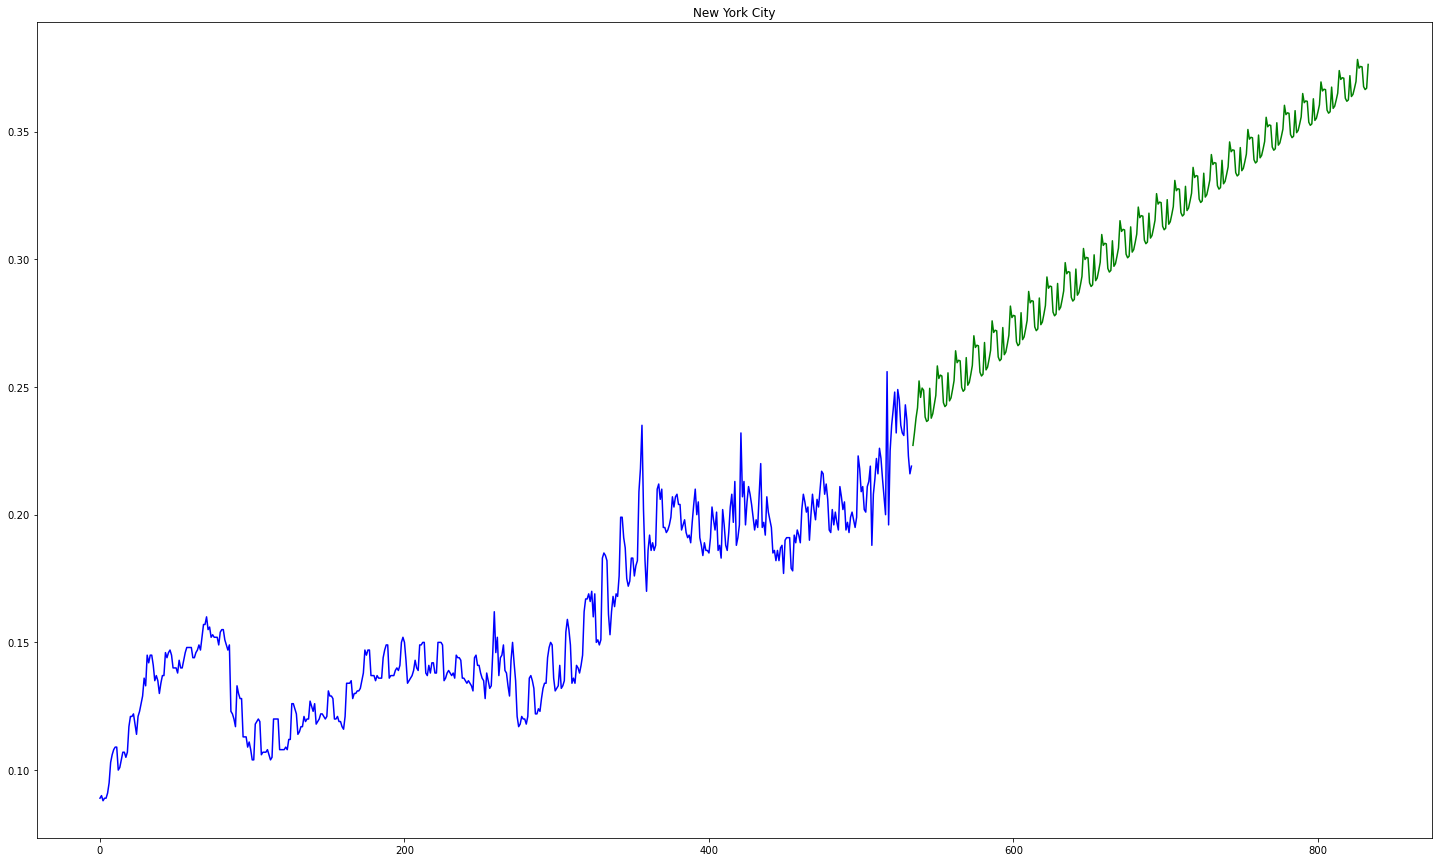

2023-07-04 04:19:52.437560  - Starting to forecast for city  Los Angeles
Capstone/models/pmdarima_model_Los Angeles2023_07.pkl
[0.26702284 0.26904241 0.26867077 0.26543112 0.26598559 0.26647744
 0.26693812 0.26755687 0.26830188 0.2686379  0.26910018 0.27252147
 0.27277462 0.27355089 0.27395956 0.27392552 0.2744775  0.27502019
 0.27555846 0.27612159 0.27670464 0.27722482 0.27776493 0.27876251
 0.27927121 0.27986097 0.28039445 0.28086002 0.2814164  0.28197173
 0.28252678 0.28308607 0.28364883 0.28420228 0.28475921 0.28538711
 0.28593998 0.28650576 0.28706325 0.28761067 0.28817249 0.28873454
 0.28929695 0.28986041 0.29042479 0.29098814 0.29155242 0.29212805
 0.29269249 0.29325933 0.29382528 0.29439007 0.29495748 0.29552532
 0.29609361 0.29666246 0.29723185 0.29780147 0.29837163 0.29894393
 0.2995149  0.30008664 0.30065864 0.30123085 0.30180385 0.30237732
 0.30295125 0.30352567 0.30410055 0.30467587 0.30525167 0.30582819
 0.30640489 0.30698211 0.30755976 0.30813784 0.30871643 0.30929548
 0

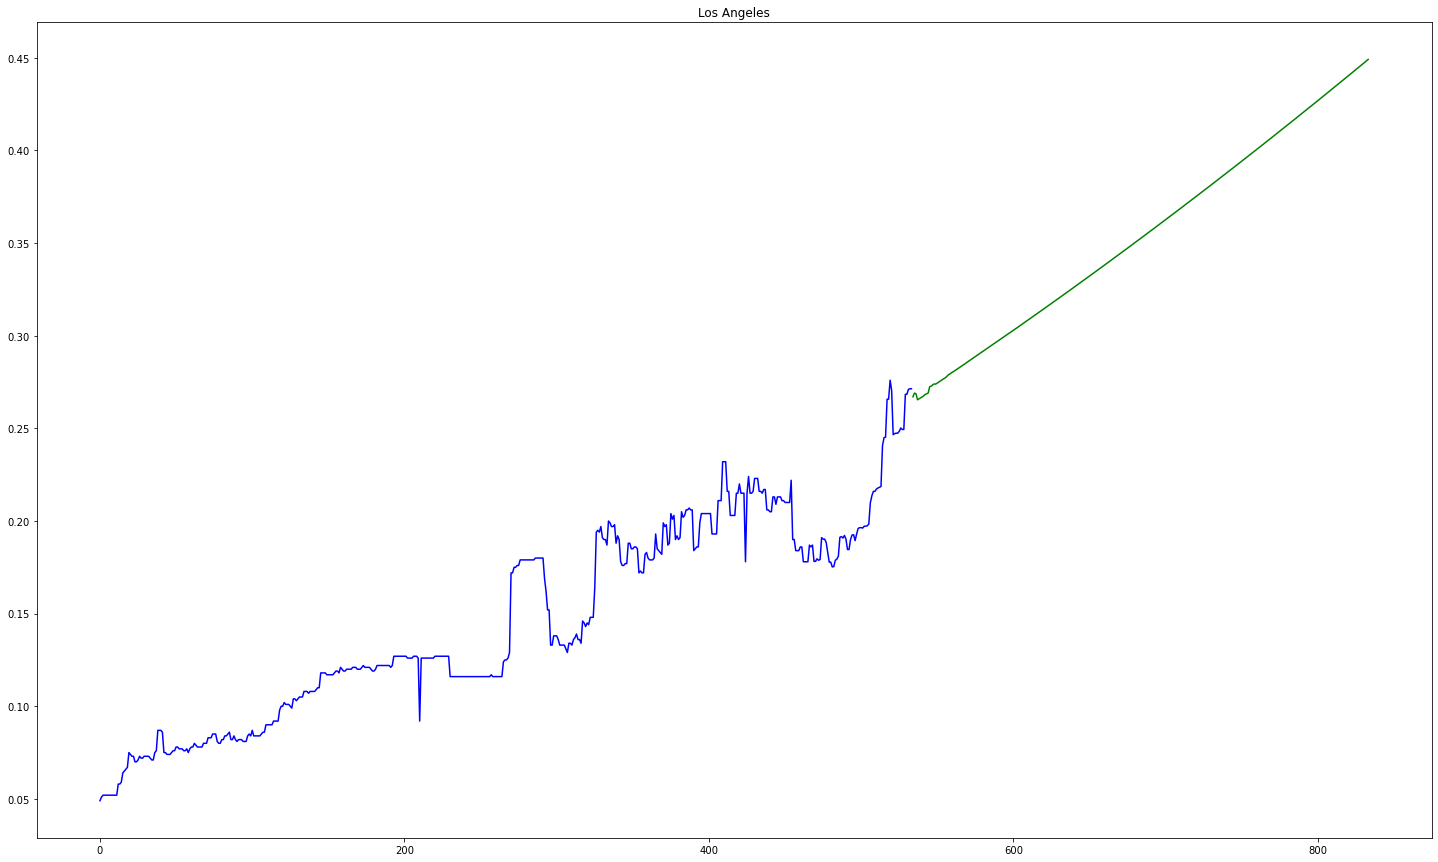

2023-07-04 04:19:52.737672  - Starting to forecast for city  Chicago
Capstone/models/pmdarima_model_Chicago2023_07.pkl
[0.16038598 0.16079616 0.1532857  0.15379258 0.14783314 0.14888426
 0.15016265 0.14904418 0.14229164 0.14242394 0.14822985 0.15074477
 0.15577759 0.15623443 0.1525111  0.15341205 0.14849441 0.14936163
 0.15041644 0.14949358 0.14392354 0.14403264 0.14882171 0.15089679
 0.15505049 0.1554276  0.15235442 0.15309798 0.14903999 0.14975551
 0.15062587 0.14986438 0.1452694  0.14535939 0.14931003 0.15102224
 0.15445031 0.15476159 0.15222512 0.15283878 0.14949012 0.1500805
 0.15079868 0.15017033 0.1463795  0.14645372 0.14971293 0.15112576
 0.15395492 0.15421185 0.15211841 0.15262485 0.14986152 0.15034866
 0.15094127 0.15042278 0.1472952  0.14735643 0.15004536 0.15121118
 0.15354604 0.1537581  0.15203035 0.1524483  0.15016797 0.15056994
 0.15105894 0.1506311  0.14805062 0.14810113 0.15031967 0.15128167
 0.15320857 0.1533836  0.15195768 0.1523026  0.15042084 0.15075252
 0.15115605

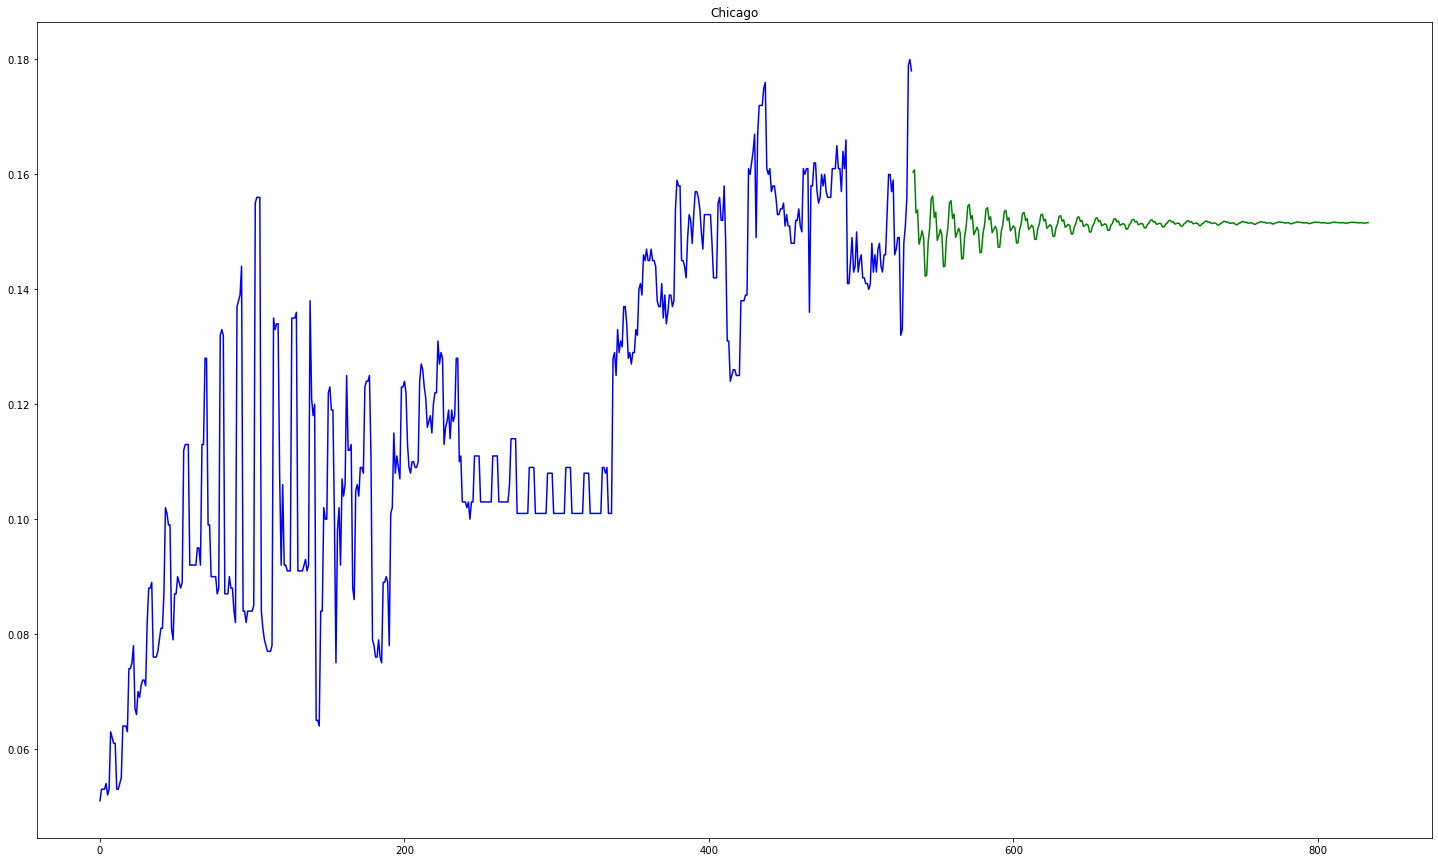

2023-07-04 04:19:53.054747  - Starting to forecast for city  Houston
Capstone/models/pmdarima_model_Houston2023_07.pkl
[0.18464842 0.17909928 0.18282335 0.19256587 0.18727773 0.20939677
 0.20986347 0.21111629 0.20298589 0.19927875 0.20304022 0.19509556
 0.19798705 0.19258739 0.19621233 0.20567291 0.20054178 0.22194489
 0.22239487 0.22360251 0.21575716 0.21217338 0.21580965 0.20812424
 0.21092366 0.20569377 0.20920577 0.21835214 0.21339486 0.234022
 0.23445428 0.23561414 0.22807205 0.22462111 0.22812256 0.22071763
 0.22341685 0.21837228 0.22176071 0.2305686  0.22579772 0.24560557
 0.24601948 0.24712985 0.23990351 0.23659215 0.23995196 0.23284273
 0.23543585 0.23058796 0.23384505 0.24229715 0.23772152 0.25668125
 0.25707643 0.25813631 0.25123328 0.24806586 0.25127961 0.24447615
 0.24695919 0.24231571 0.24543612 0.25352121 0.24914645 0.2672417
 0.26761798 0.26862701 0.26205068 0.25902954 0.26209485 0.25560278
 0.25797343 0.25353894 0.25651947 0.26423151 0.26006048 0.27728545
 0.27764288 0

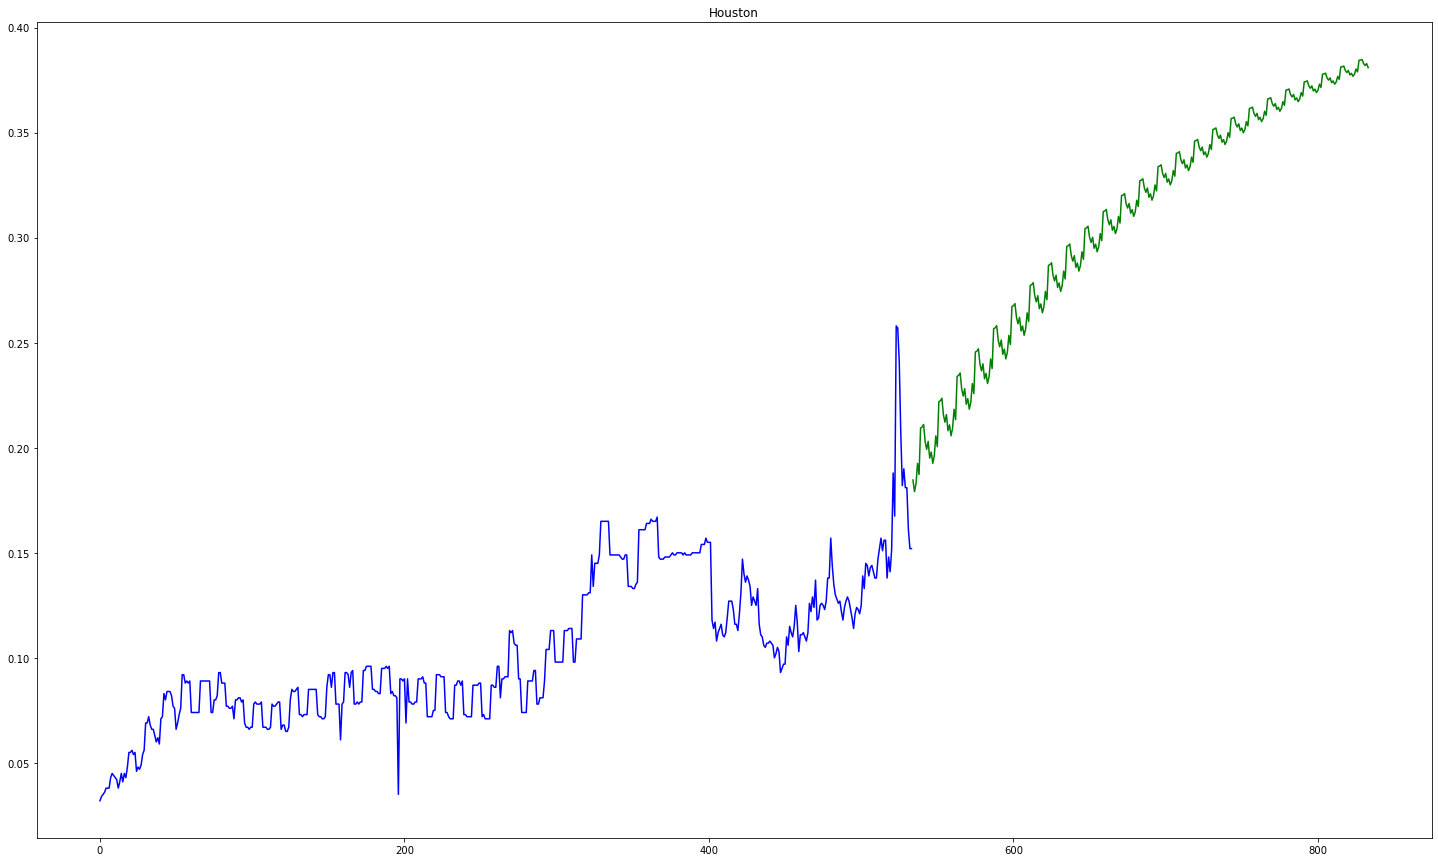

2023-07-04 04:19:53.355404  - Starting to forecast for city  Phoenix
Capstone/models/pmdarima_model_Phoenix2023_07.pkl
[0.13719254 0.13740084 0.1376432  0.15478016 0.15441229 0.15614781
 0.15543201 0.15244348 0.15274696 0.13738905 0.13844339 0.13892163
 0.1396434  0.13984025 0.14006929 0.15623091 0.15588462 0.15751809
 0.15684446 0.15403085 0.15431665 0.13982911 0.14082538 0.14127719
 0.14195897 0.1421449  0.14236121 0.15759629 0.15727042 0.15880739
 0.15817361 0.15552553 0.15579459 0.14213438 0.14307521 0.14350181
 0.14414546 0.14432097 0.14452515 0.15888096 0.15857438 0.16002016
 0.15942404 0.15693247 0.15718569 0.14431104 0.14519904 0.14560162
 0.14620895 0.14637455 0.14656718 0.16008935 0.159801   0.16116065
 0.16060009 0.15825642 0.15849466 0.14636517 0.1472029  0.14758262
 0.14815541 0.14831157 0.14849323 0.16122572 0.16095458 0.16223293
 0.16170593 0.15950194 0.15972602 0.14830273 0.14909265 0.14945066
 0.14999063 0.15013783 0.15030906 0.1622941  0.1620392  0.16324086
 0.1627455

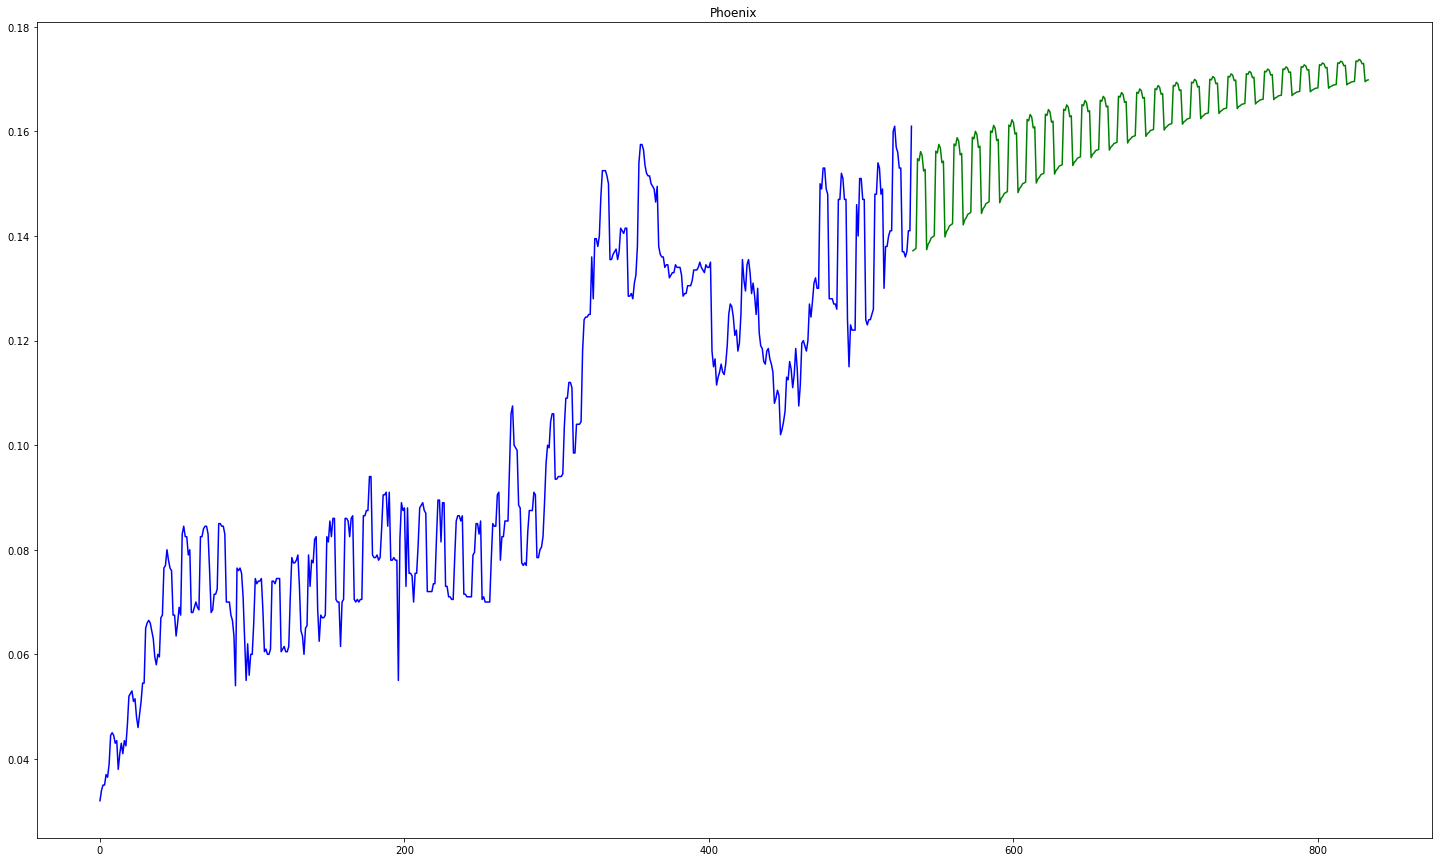

2023-07-04 04:19:53.639057  - Starting to forecast for city  Philadelphia
Capstone/models/pmdarima_model_Philadelphia2023_07.pkl
[0.19716861 0.19773536 0.19825137 0.19914896 0.20440229 0.20461022
 0.20400147 0.20569381 0.20332928 0.20337964 0.20878082 0.21130709
 0.21176208 0.2121317  0.21254729 0.21322129 0.21739312 0.21760245
 0.21710761 0.21837133 0.21645039 0.21662932 0.22095394 0.22310694
 0.22351549 0.22383957 0.2242024  0.22479096 0.22843723 0.22862033
 0.22818751 0.229293   0.22761277 0.22776924 0.23155379 0.23344005
 0.23379815 0.23408223 0.23440033 0.2349164  0.23811583 0.23827659
 0.23789659 0.23886728 0.23739208 0.23752942 0.24085345 0.24251166
 0.24282657 0.24307642 0.24335621 0.24381019 0.24662623 0.2467678
 0.24643318 0.24728802 0.24598897 0.24610988 0.2490379  0.2504996
 0.25077727 0.25099759 0.25124432 0.25164472 0.25412949 0.25425445
 0.25395908 0.2547137  0.25356702 0.25367374 0.25625896 0.25755028
 0.25779564 0.25799034 0.25820839 0.25856227 0.2607592  0.26086972
 0

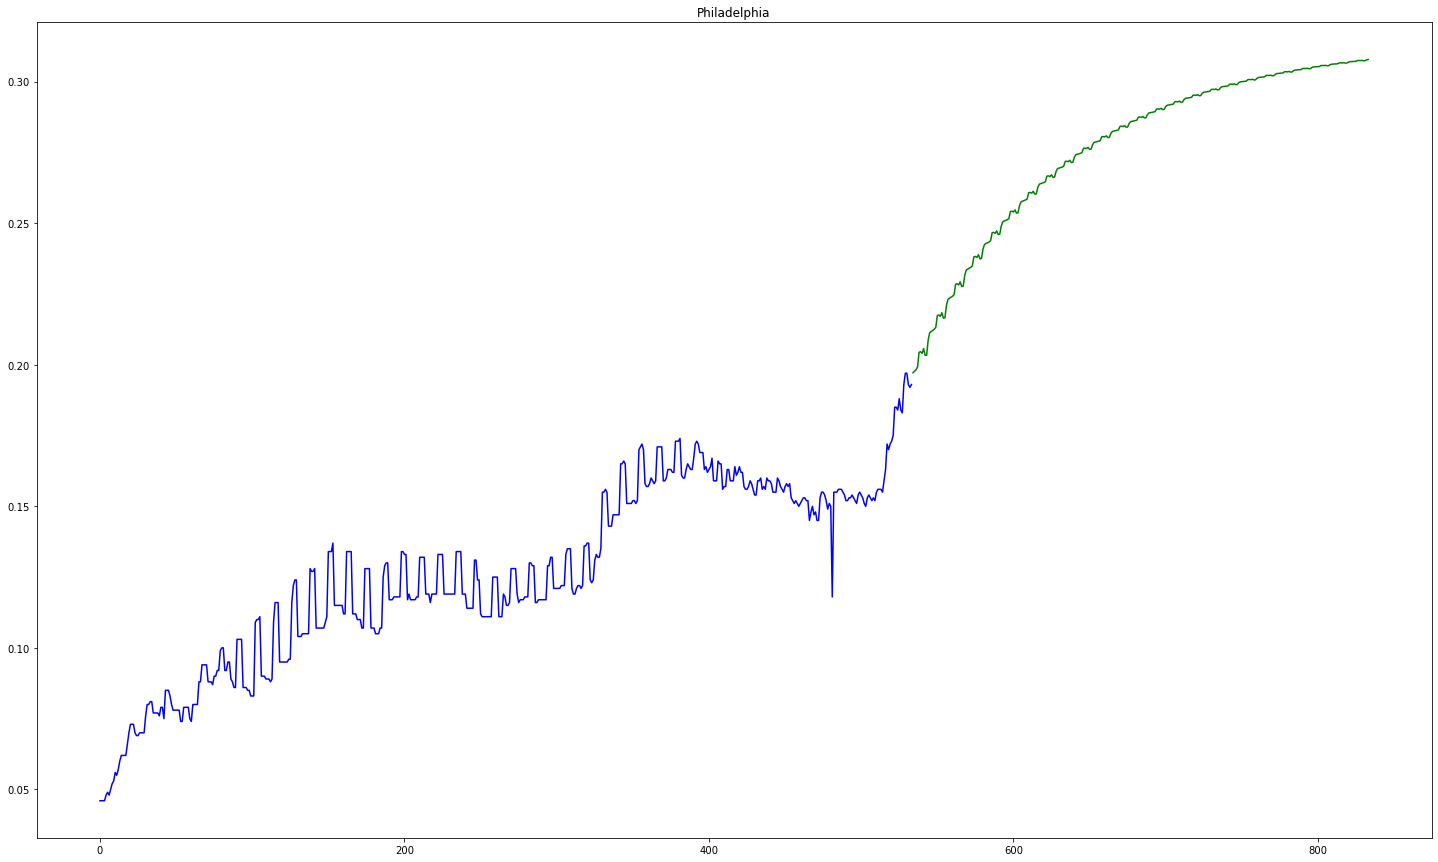

2023-07-04 04:19:53.996734  - Starting to forecast for city  San Diego
Capstone/models/pmdarima_model_San Diego2023_07.pkl
[ 0.47800777  0.48104244  0.4831398   0.48622051  0.48932897  0.49246548
  0.49563039  0.49882401  0.5020467   0.50540298  0.50868576  0.51825597
  0.52192195  0.52562455  0.52927938  0.53305581  0.5368703   0.54072334
  0.54461545  0.54854713  0.5525189   0.55654054  0.56059419  0.56524173
  0.56940826  0.57361818  0.57786462  0.582163    0.58650654  0.59089586
  0.59533159  0.59981435  0.60434481  0.60892442  0.61355223  0.61827831
  0.62300876  0.62779035  0.63262312  0.63750912  0.64244844  0.64744182
  0.65249004  0.65759387  0.66275411  0.66797163  0.67324712  0.67858577
  0.68398007  0.68943497  0.69495127  0.70053     0.70617202  0.71187824
  0.71764961  0.7234871   0.72939169  0.73536438  0.74140618  0.74751851
  0.75370167  0.75995712  0.76628592  0.77268922  0.77916813  0.78572381
  0.79235745  0.79907024  0.8058634   0.81273818  0.81969584  0.82673773
 

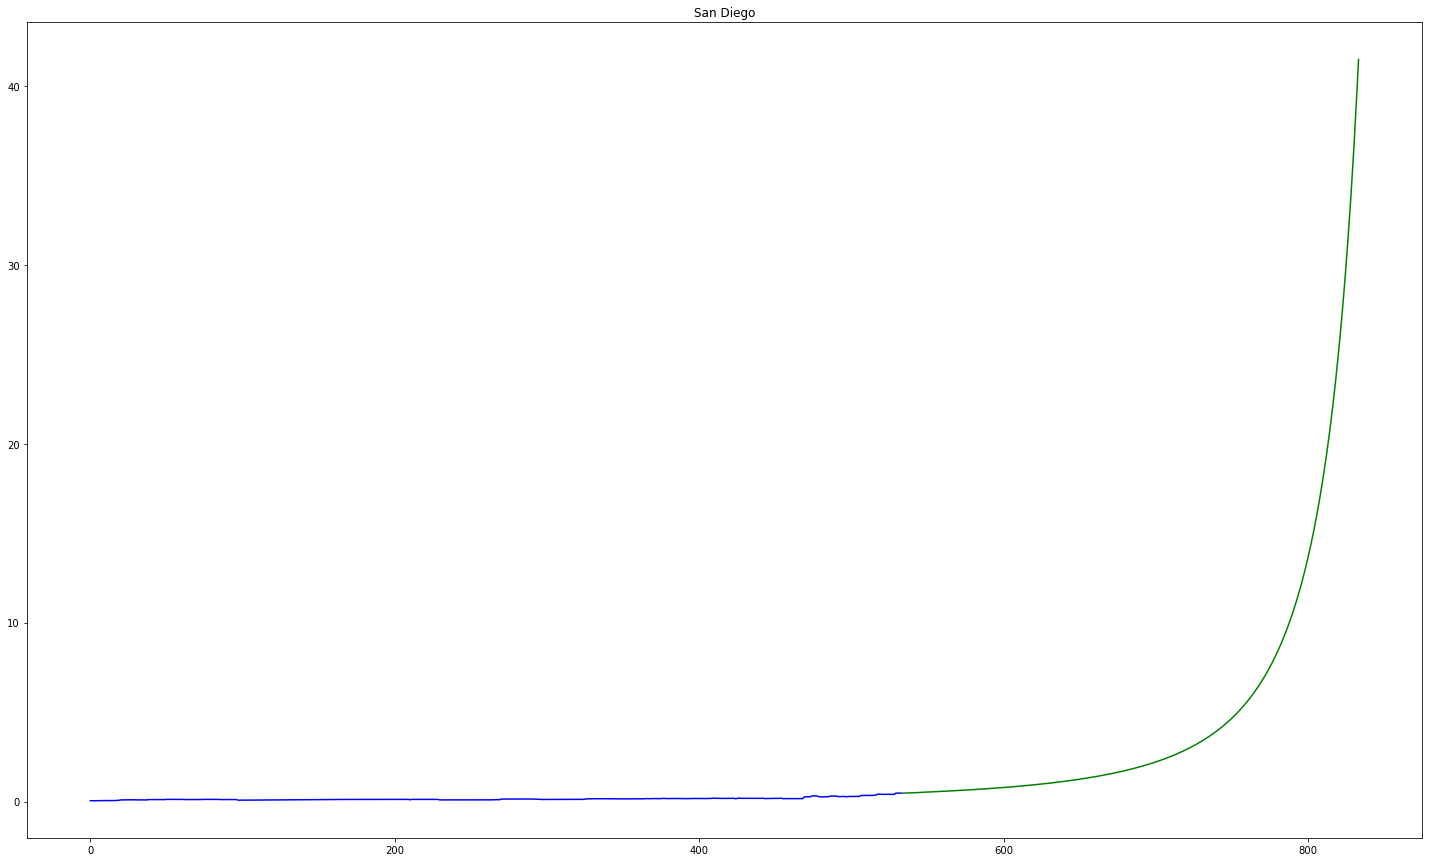

2023-07-04 04:19:54.300129  - Starting to forecast for city  Dallas
Capstone/models/pmdarima_model_Dallas2023_07.pkl
[0.1828409  0.18143    0.18246054 0.18468741 0.19050427 0.19807049
 0.19818515 0.19822925 0.19800651 0.19080731 0.19087835 0.19028893
 0.19198212 0.19076123 0.19096753 0.19364372 0.19699304 0.20121244
 0.20369937 0.20562187 0.20571138 0.2016414  0.20169232 0.20295333
 0.20346022 0.20212518 0.20283724 0.20523097 0.21007789 0.21631038
 0.21734075 0.21810693 0.21800551 0.21204541 0.21210842 0.21222662
 0.21345979 0.21220162 0.21259956 0.21515379 0.21905122 0.22400106
 0.22591634 0.22738346 0.22739971 0.22264574 0.22270087 0.22351561
 0.22429547 0.22300075 0.22358717 0.22602162 0.23046023 0.23613504
 0.23749117 0.23851531 0.23845994 0.23302715 0.23308648 0.23346816
 0.23451556 0.23325728 0.23372254 0.2362026  0.24025854 0.24541791
 0.24709464 0.24837282 0.24836168 0.24341642 0.24347241 0.24411164
 0.24498252 0.24371924 0.24425171 0.24666973 0.25089794 0.25628736
 0.25774271 

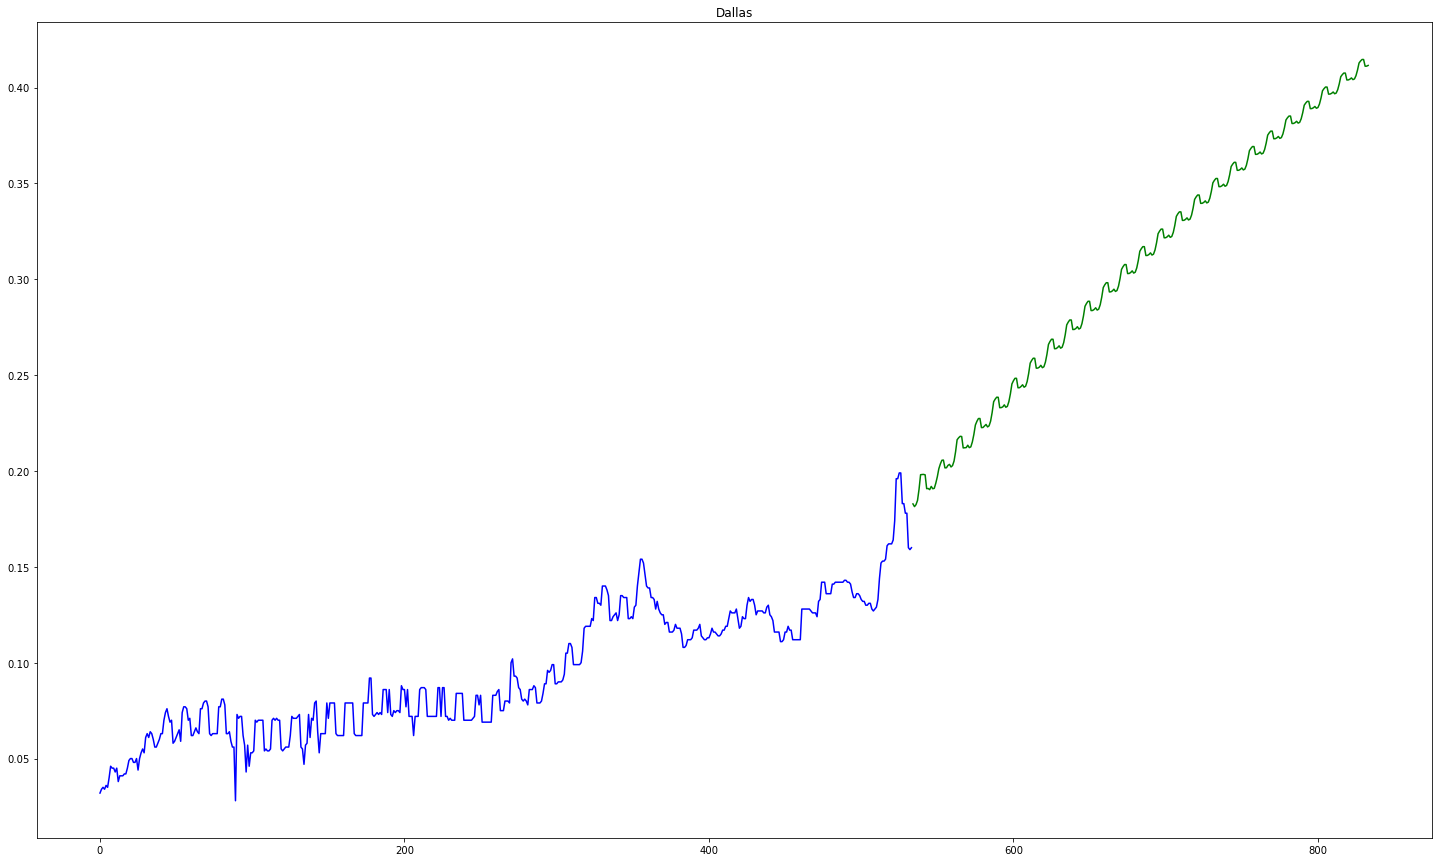

2023-07-04 04:19:54.658514  - Starting to forecast for city  Seattle
Capstone/models/pmdarima_model_Seattle2023_07.pkl
[0.12537976 0.12542832 0.12554566 0.12548531 0.12548529 0.12548529
 0.12548529 0.12548529 0.12548529 0.12548529 0.12548529 0.12597444
 0.12593619 0.12593918 0.12594641 0.12594269 0.12594269 0.12594269
 0.12594269 0.12594269 0.12594269 0.12594269 0.12594269 0.12597286
 0.1259705  0.12597068 0.12597113 0.1259709  0.1259709  0.1259709
 0.1259709  0.1259709  0.1259709  0.1259709  0.1259709  0.12597276
 0.12597261 0.12597263 0.12597265 0.12597264 0.12597264 0.12597264
 0.12597264 0.12597264 0.12597264 0.12597264 0.12597264 0.12597275
 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275
 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275
 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275
 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275
 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275 0.12597275
 0.12597275

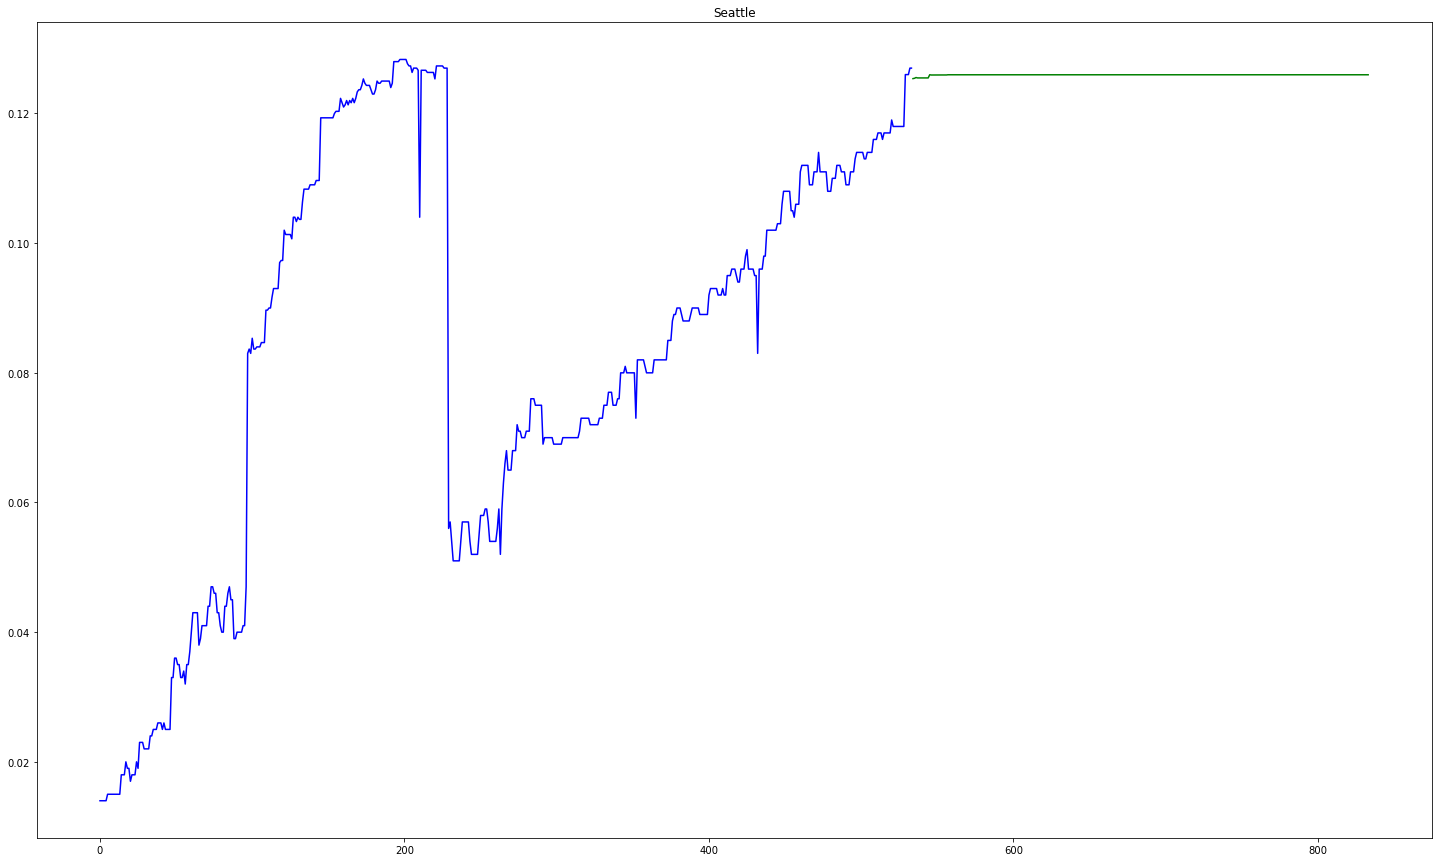

2023-07-04 04:19:54.971055  - Starting to forecast for city  San Francisco
Capstone/models/pmdarima_model_San Francisco2023_07.pkl
[0.31660752 0.32546561 0.3234851  0.32933306 0.33154634 0.33147663
 0.33147073 0.33151032 0.33000519 0.32562287 0.32574537 0.33199064
 0.33191072 0.33956551 0.3378612  0.3436439  0.34555689 0.34548801
 0.34548476 0.34552388 0.34416952 0.33983685 0.33995926 0.3458108
 0.34574539 0.35303675 0.3514138  0.3569195  0.35874005 0.3586745
 0.35867141 0.35870863 0.35741976 0.35329523 0.35341179 0.35898166
 0.35891941 0.36585462 0.36431144 0.3695454  0.3712754  0.37121312
 0.37121018 0.37124555 0.37002081 0.36610037 0.36621119 0.37150496
 0.37144582 0.37803283 0.37656755 0.38153633 0.38317808 0.38311898
 0.38311619 0.38314975 0.38198752 0.37826615 0.37837136 0.38339591
 0.38333979 0.38958801 0.38819846 0.39290962 0.39446573 0.39440972
 0.39440707 0.39443888 0.39333729 0.38980925 0.38990902 0.39467218
 0.39461899 0.40053891 0.39922268 0.40368454 0.40515787 0.40510484


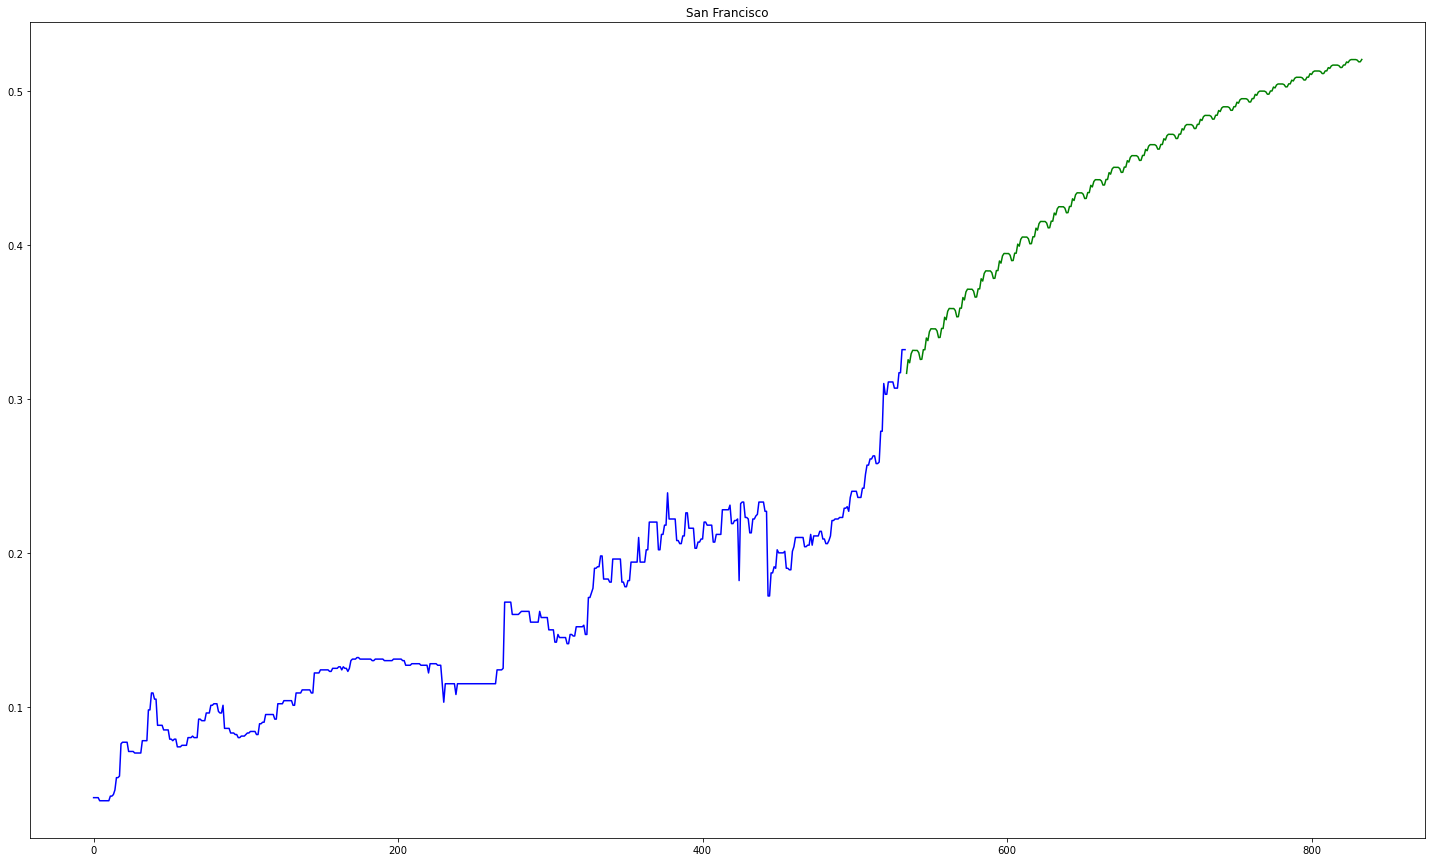

2023-07-04 04:19:55.321624  - Starting to forecast for city  Denver
Capstone/models/pmdarima_model_Denver2023_07.pkl
[0.15299979 0.15407214 0.15344104 0.1400847  0.14008276 0.14044627
 0.14044627 0.14101097 0.13970186 0.13907078 0.13906769 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745 0.13892745
 0.13892745 

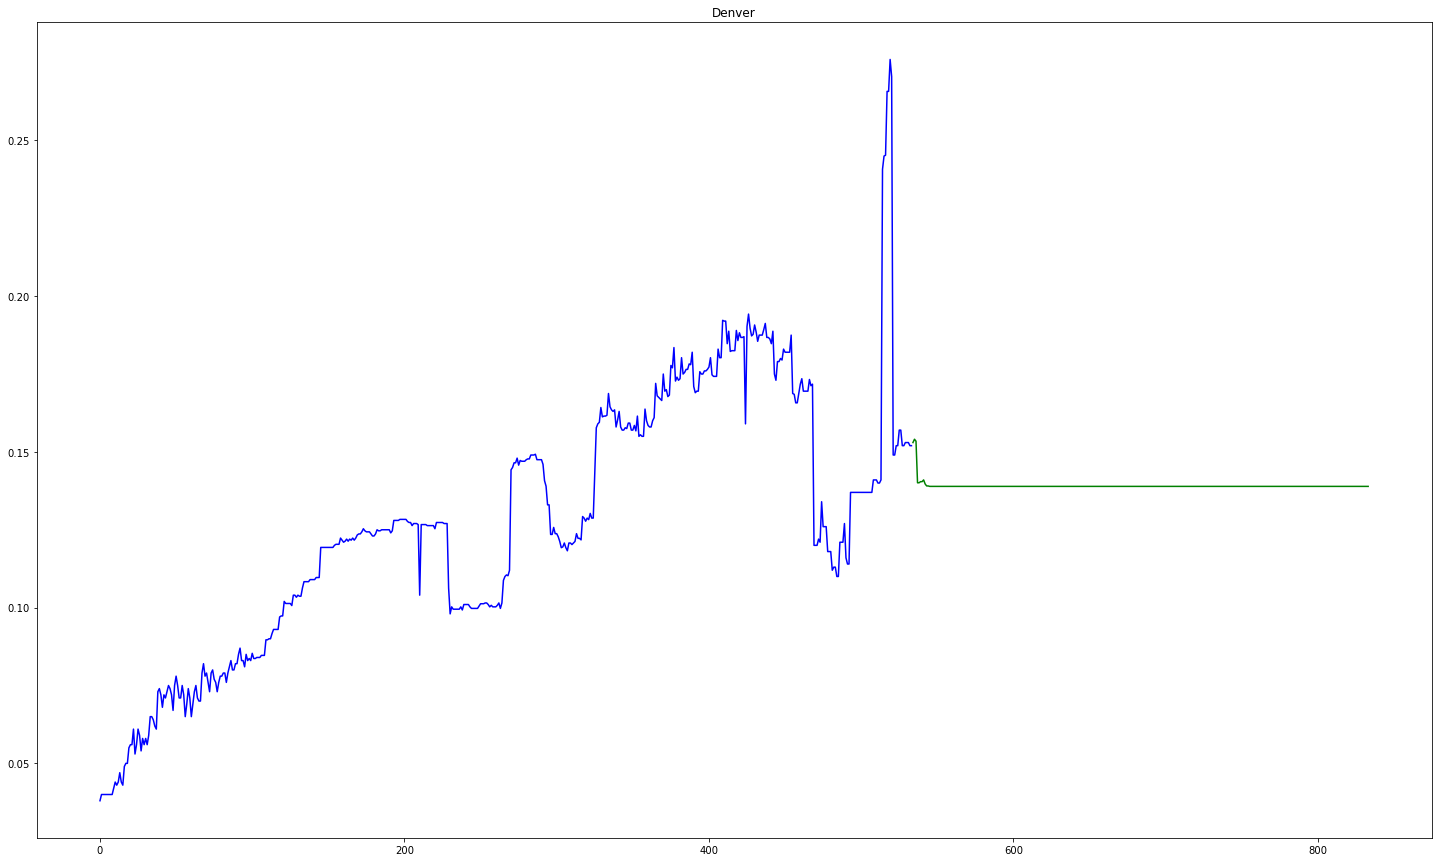

2023-07-04 04:19:55.609305  - Starting to forecast for city  Washington
Capstone/models/pmdarima_model_Washington2023_07.pkl
[0.14517914 0.14507528 0.14486626 0.14275297 0.14949635 0.15071427
 0.15101441 0.15182683 0.14625715 0.14549791 0.14598439 0.15241078
 0.15083085 0.15094292 0.15086581 0.14884419 0.1555935  0.15683277
 0.15714893 0.15796668 0.1524398  0.15168897 0.15217501 0.15856121
 0.15699315 0.157105   0.15702875 0.15502067 0.16172259 0.16295231
 0.16326602 0.16407724 0.1585923  0.15784675 0.1583294  0.16466697
 0.16311153 0.1632225  0.16314685 0.16115431 0.16780161 0.16902047
 0.16933136 0.17013524 0.16469781 0.16395832 0.16443706 0.17071956
 0.16917827 0.16928824 0.16921327 0.16723826 0.17382447 0.17503133
 0.17533912 0.17613492 0.17075011 0.1700174  0.17049176 0.1767133
 0.17518756 0.17529643 0.17522221 0.17326658 0.17978576 0.18097961
 0.18128405 0.18207111 0.17674355 0.17601827 0.17648783 0.18264307
 0.18113413 0.18124182 0.18116841 0.17923382 0.18568062 0.18686053
 0.18

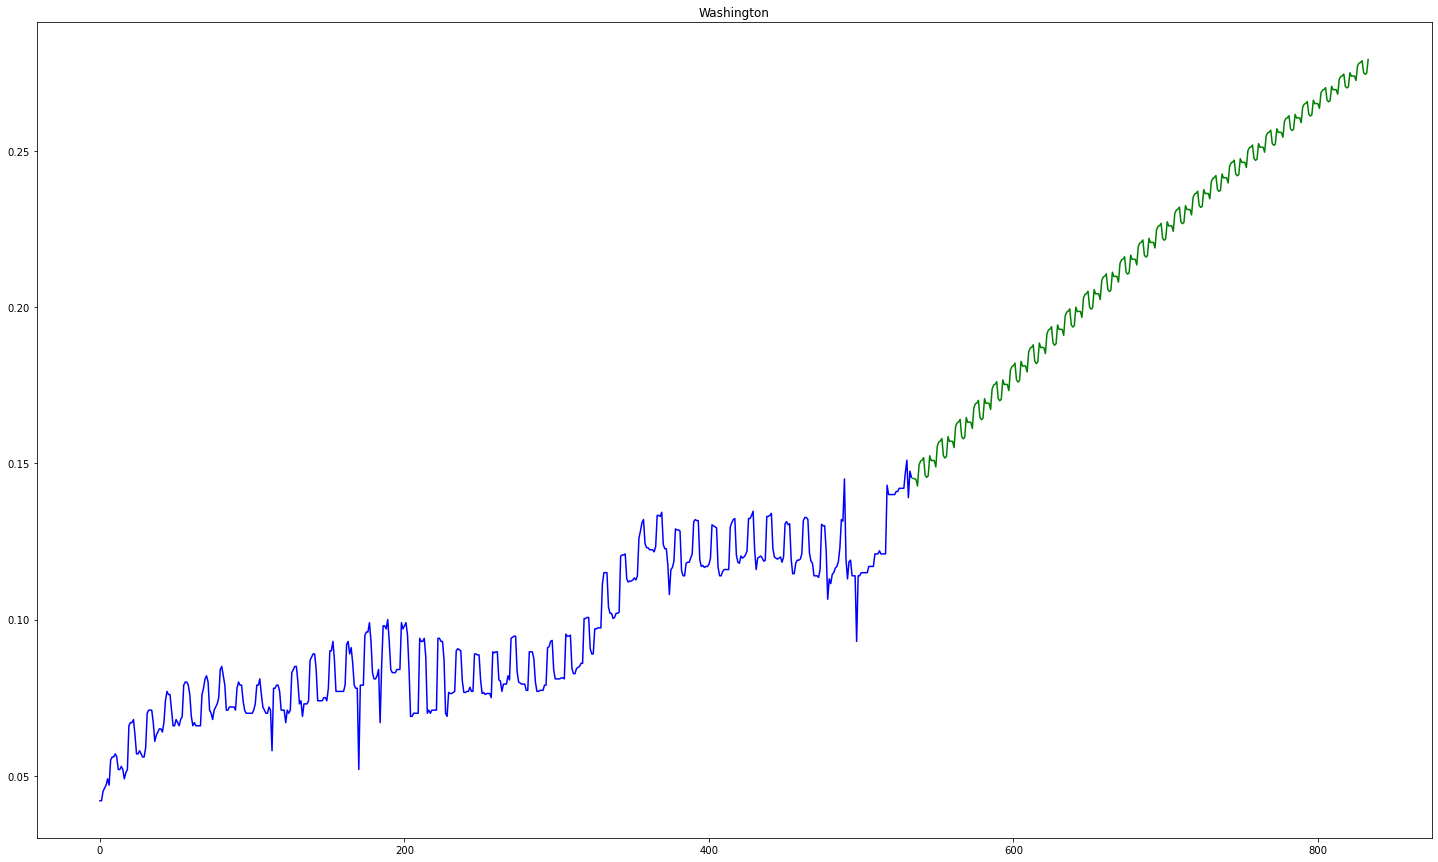

2023-07-04 04:19:55.904332  - Starting to forecast for city  Detroit
Capstone/models/pmdarima_model_Detroit2023_07.pkl
[0.18262951 0.183388   0.18439153 0.18557677 0.19127428 0.19257597
 0.19224468 0.19299287 0.19327266 0.18636467 0.18843358 0.18941422
 0.18978545 0.19021143 0.19108968 0.19207158 0.19720563 0.1983666
 0.19814355 0.19885089 0.19918017 0.19306848 0.19500042 0.1959455
 0.19635786 0.19681174 0.19767752 0.19863144 0.203295   0.20440872
 0.20429229 0.2050032  0.20537896 0.19999834 0.20180829 0.20273408
 0.203184   0.20367095 0.20452699 0.20546186 0.20970927 0.21078608
 0.21076661 0.21148495 0.21190476 0.20717915 0.20888289 0.209795
 0.21028157 0.21080152 0.21165207 0.21257336 0.21645391 0.21750155
 0.2175715  0.21829996 0.21876233 0.214624   0.21623607 0.2171394
 0.21766213 0.21821502 0.21906411 0.21997676 0.22353425 0.22455963
 0.22471257 0.22545368 0.2259575  0.22234645 0.22388004 0.22477908
 0.22533771 0.22592364 0.22677503 0.2276836  0.23095696 0.23196633
 0.23219681 0.2

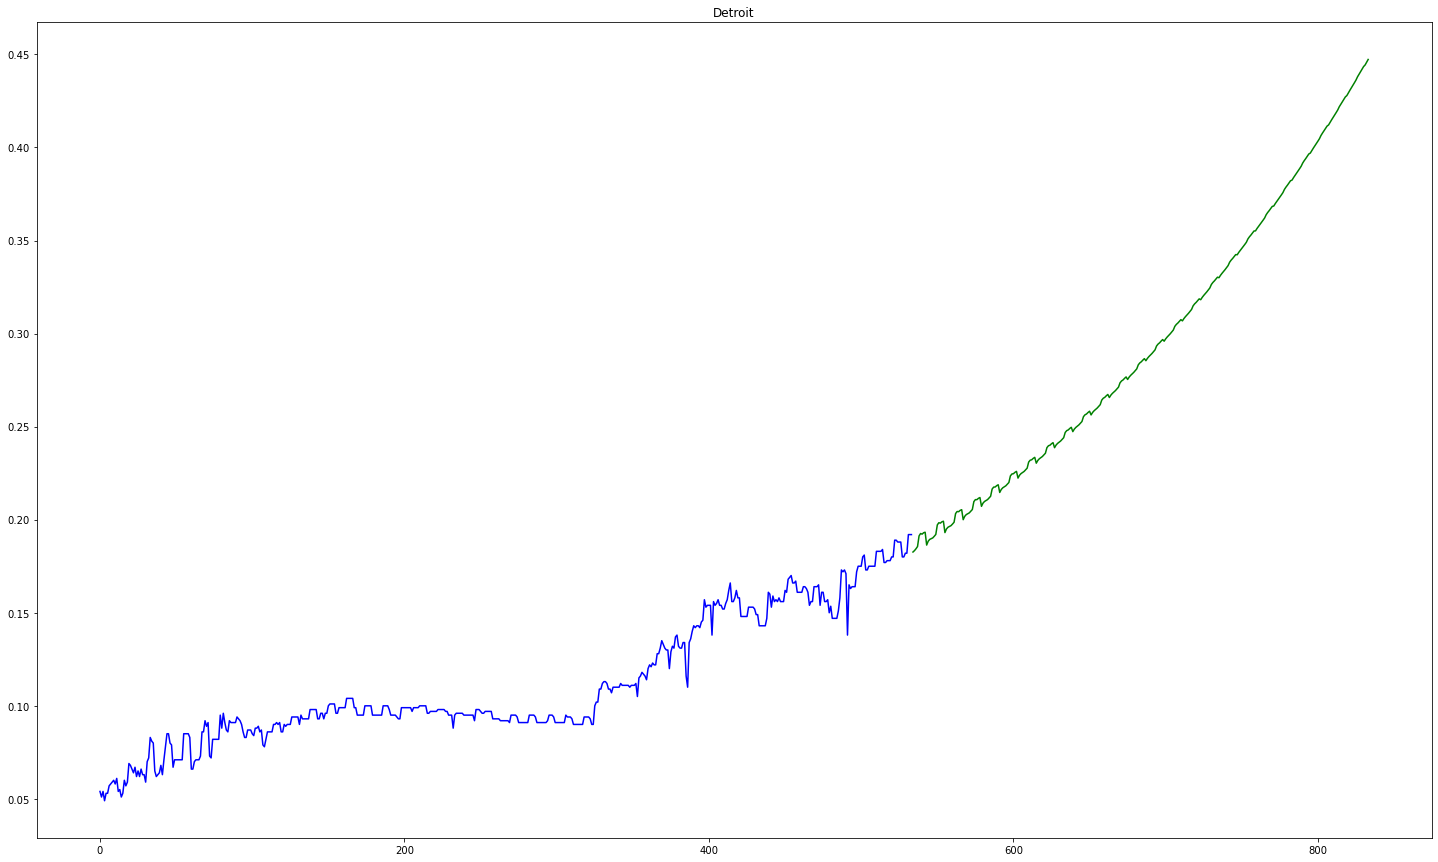

2023-07-04 04:19:56.237559  - Starting to forecast for city  Portland
Capstone/models/pmdarima_model_Portland2023_07.pkl
[0.26889475 0.27182368 0.27107953 0.26664913 0.26757447 0.26798674
 0.26830727 0.26885246 0.27156362 0.2718919  0.27222223 0.27848647
 0.27940725 0.28145719 0.28113917 0.27841066 0.27918129 0.2796167
 0.27999217 0.28051444 0.2824518  0.28283237 0.28321428 0.28747242
 0.28824002 0.28974509 0.28970362 0.28808766 0.28875723 0.28920784
 0.28961931 0.29012668 0.29155836 0.29197318 0.2923889  0.29533623
 0.29600384 0.29715305 0.29729231 0.29640332 0.29700694 0.29746758
 0.29790266 0.29840037 0.29950174 0.29993903 0.30037691 0.30246804
 0.30307042 0.3039873  0.30424468 0.30383062 0.30439125 0.30485852
 0.30530911 0.3058006  0.30668629 0.30713835 0.30759079 0.30912279
 0.30968266 0.3104479  0.31078252 0.3106787  0.31121135 0.31168303
 0.31214383 0.31263135 0.31337627 0.31383805 0.31430009 0.31546703
 0.31599923 0.31666553 0.31705066 0.31714954 0.31766399 0.31813864
 0.318606

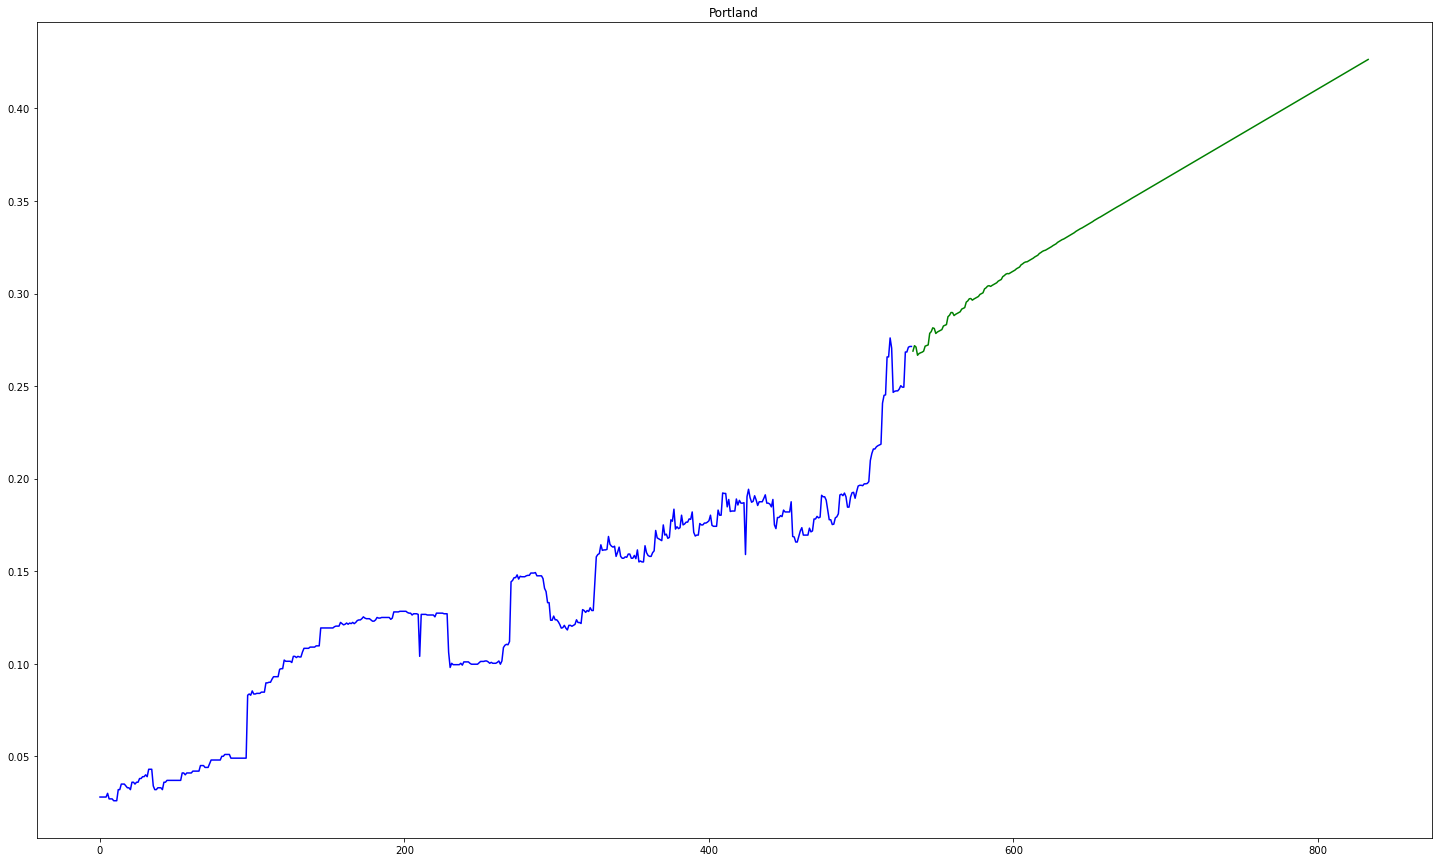

2023-07-04 04:19:56.587699  - Starting to forecast for city  Boston
Capstone/models/pmdarima_model_Boston2023_07.pkl
[0.39106724 0.39364368 0.3946636  0.38251229 0.38387999 0.37970944
 0.3833955  0.3836791  0.38333481 0.40860924 0.40880684 0.42800655
 0.42769354 0.42934068 0.43040839 0.41767893 0.41911267 0.41473997
 0.41860481 0.41890209 0.41854118 0.44499423 0.44520073 0.46524184
 0.46491547 0.46663278 0.4677458  0.45446722 0.45596379 0.45139869
 0.45543371 0.455744   0.45536729 0.4829371  0.48315199 0.50398447
 0.50364558 0.50542865 0.50658411 0.49279007 0.49434573 0.48959958
 0.49379474 0.49411727 0.49372571 0.52234113 0.52256385 0.54413122
 0.54378074 0.54562465 0.54681936 0.53254765 0.53415818 0.52924382
 0.53358779 0.53392169 0.53351632 0.5630979  0.5633278  0.58556795
 0.5852069  0.58710626 0.58833673 0.57362878 0.57528955 0.5702211
 0.5747014  0.57504569 0.5746277  0.60508869 0.6053251  0.62817108
 0.62780056 0.62974961 0.63101208 0.61591242 0.61761842 0.61241111
 0.61701428 0

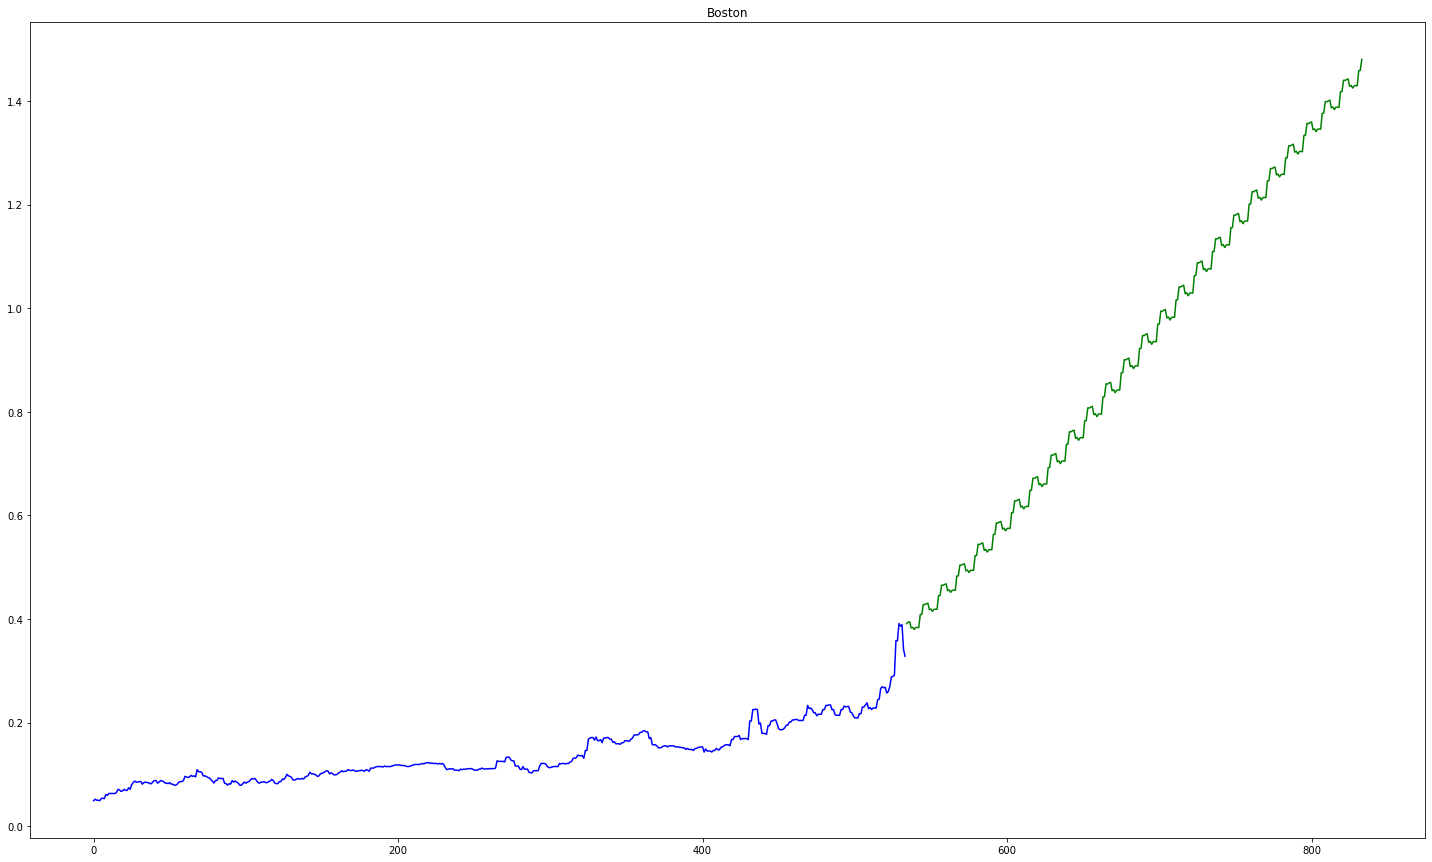

2023-07-04 04:19:56.942221  - Starting to forecast for city  Baltimore
Capstone/models/pmdarima_model_Baltimore2023_07.pkl
[0.14514914 0.14492647 0.14482537 0.14262054 0.14776561 0.14898316
 0.14934205 0.15011149 0.14655678 0.14582969 0.14629696 0.152349
 0.1507874  0.15080527 0.15077294 0.14866743 0.15368134 0.15487282
 0.15522662 0.15597572 0.15252976 0.15182499 0.15227903 0.15814734
 0.15663443 0.15665183 0.15662055 0.15457933 0.15943802 0.16059152
 0.16093397 0.1616589  0.15832277 0.15764004 0.1580799  0.16375956
 0.16229623 0.16231307 0.1622828  0.16030743 0.16500742 0.16612226
 0.16645316 0.16715354 0.16392919 0.16326895 0.16369433 0.16918224
 0.16776917 0.16778543 0.1677562  0.16584773 0.1703868  0.1714626
 0.17178185 0.17245747 0.16934601 0.16870855 0.16911927 0.17441374
 0.17305123 0.17306691 0.17303872 0.17119771 0.17557478 0.17661141
 0.17691898 0.17756979 0.17457162 0.17395705 0.17435303 0.17945359
 0.17814166 0.17815676 0.17812961 0.17635619 0.18057116 0.18156871
 0.181864

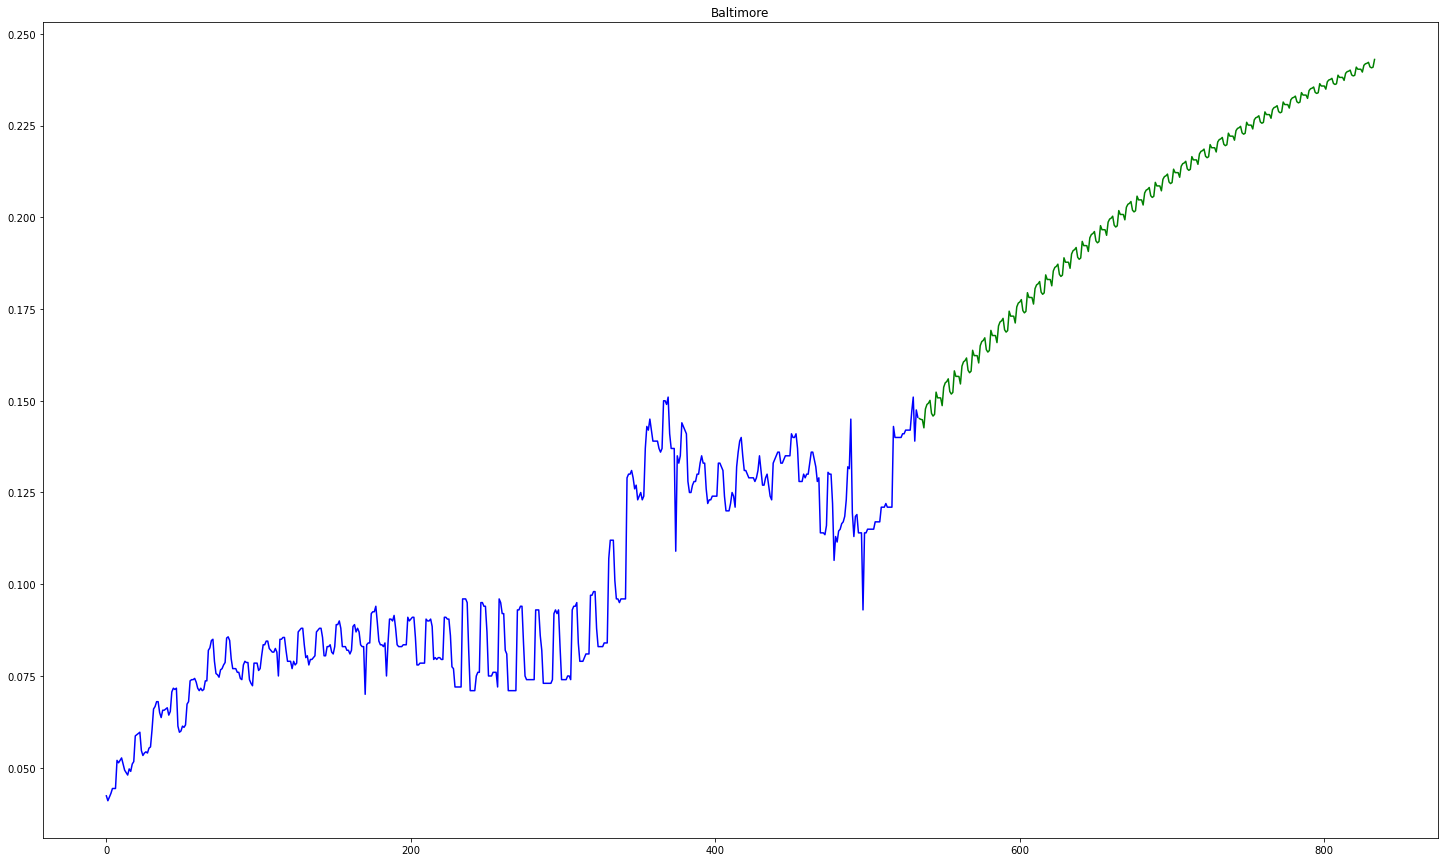

2023-07-04 04:19:57.257919  - Starting to forecast for city  Milwaukee
Capstone/models/pmdarima_model_Milwaukee2023_07.pkl
[0.16630483 0.16687335 0.16647477 0.16822169 0.17355646 0.17383111
 0.17404627 0.17399795 0.1675983  0.16453175 0.1664865  0.16802162
 0.16942725 0.16995538 0.16963826 0.17119843 0.17589716 0.17616913
 0.17638905 0.17637851 0.17081132 0.16815951 0.16990178 0.17127673
 0.17253832 0.1730321  0.17278633 0.17418309 0.17832544 0.17859508
 0.17881921 0.17884174 0.17400289 0.17171413 0.17327042 0.17450522
 0.17564079 0.17610454 0.17592122 0.17717501 0.18083064 0.18109828
 0.18132611 0.18137759 0.177176   0.17520503 0.17659856 0.17771073
 0.17873603 0.17917353 0.17904489 0.18017361 0.18340346 0.18366938
 0.18390047 0.1839773  0.18033329 0.17864047 0.17989156 0.18089644
 0.18182528 0.18223983 0.18215906 0.18317837 0.18603575 0.18630019
 0.18653416 0.18663319 0.18347703 0.18202766 0.18315413 0.18406513
 0.18490959 0.18530409 0.18526523 0.18618883 0.18872038 0.18898355
 0.189

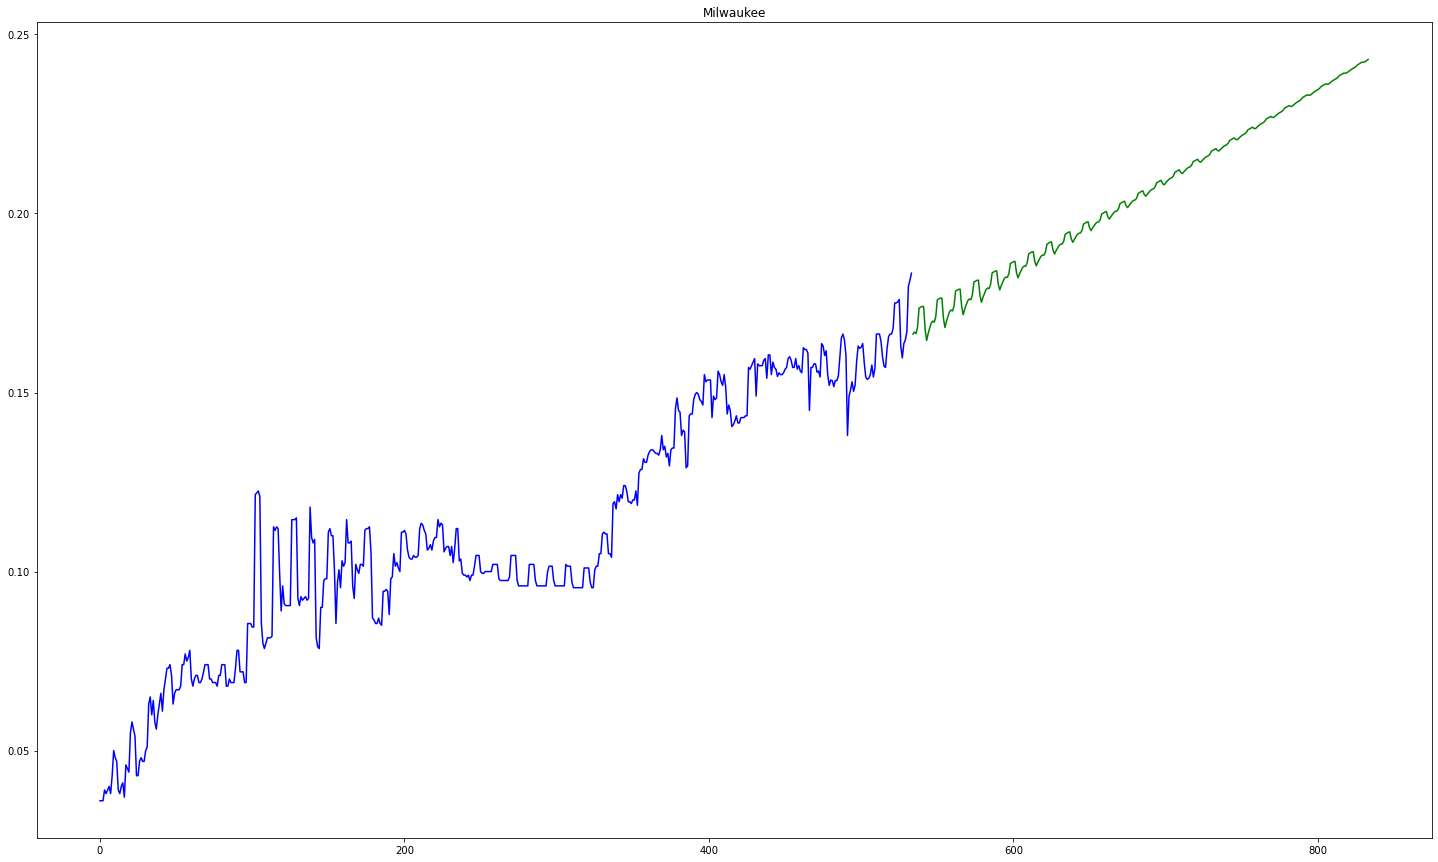

2023-07-04 04:19:57.585362  - Starting to forecast for city  Kansas City
Capstone/models/pmdarima_model_Kansas City2023_07.pkl
[0.16659028 0.16718368 0.1666687  0.16848371 0.17425377 0.17442307
 0.17459523 0.17450726 0.16720385 0.1639365  0.16602024 0.16761938
 0.16924064 0.16976993 0.16931059 0.17092937 0.17607353 0.17622441
 0.17637785 0.17629945 0.16978791 0.16687315 0.16873215 0.17015853
 0.17160437 0.17207634 0.17166675 0.17311013 0.17769525 0.1778297
 0.17796643 0.17789656 0.17209238 0.16949295 0.17115093 0.17242284
 0.17371191 0.17413266 0.17376752 0.17505419 0.17914023 0.17926002
 0.17938183 0.17931959 0.17414696 0.17182937 0.17330766 0.17444155
 0.17559058 0.17596559 0.17564015 0.17678688 0.18042754 0.18053425
 0.18064276 0.18058731 0.17597833 0.17391249 0.17523026 0.17624088
 0.17726489 0.17759907 0.17730906 0.17833088 0.18157423 0.18166928
 0.18176593 0.18171654 0.17761042 0.17576936 0.17694379 0.17784438
 0.17875679 0.17905454 0.17879615 0.17970653 0.18259554 0.18268019
 0.

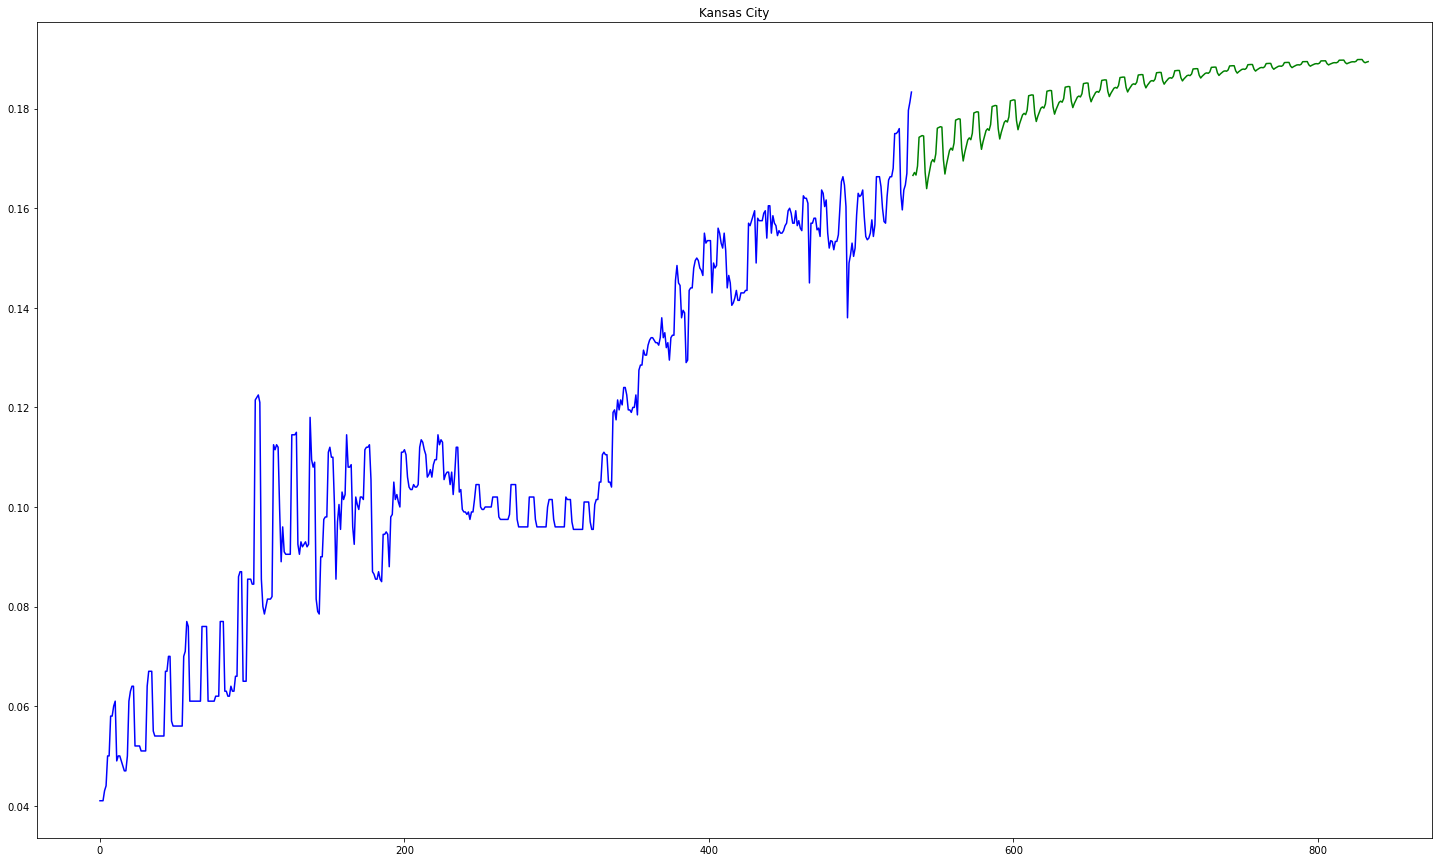

2023-07-04 04:19:57.920880  - Starting to forecast for city  Atlanta
Capstone/models/pmdarima_model_Atlanta2023_07.pkl
[0.14419    0.1438464  0.14409182 0.1433805  0.14900686 0.15058664
 0.15095399 0.15079587 0.14718752 0.14750054 0.14734164 0.15583205
 0.15318534 0.15313452 0.15323285 0.15220411 0.15754801 0.15910025
 0.1594611  0.15930578 0.1557596  0.15606735 0.15591113 0.1642497
 0.16165227 0.16160237 0.16169891 0.16068885 0.16593282 0.16745474
 0.16780847 0.16765622 0.16417862 0.16448055 0.16432729 0.17249962
 0.16995569 0.16990681 0.17000139 0.16901174 0.17414726 0.17563656
 0.17598263 0.17583368 0.17243003 0.17272564 0.17257559 0.18056975
 0.17808282 0.17803502 0.1781275  0.17715966 0.18217974 0.18363454
 0.18397253 0.18382706 0.18050173 0.18079063 0.18064399 0.18845026
 0.18602315 0.18597649 0.18606677 0.18512189 0.19002087 0.19143966
 0.19176923 0.19162739 0.18838389 0.18866577 0.18852269 0.19613333
 0.19376828 0.1937228  0.19381079 0.19288979 0.19766322 0.19904483
 0.19936571

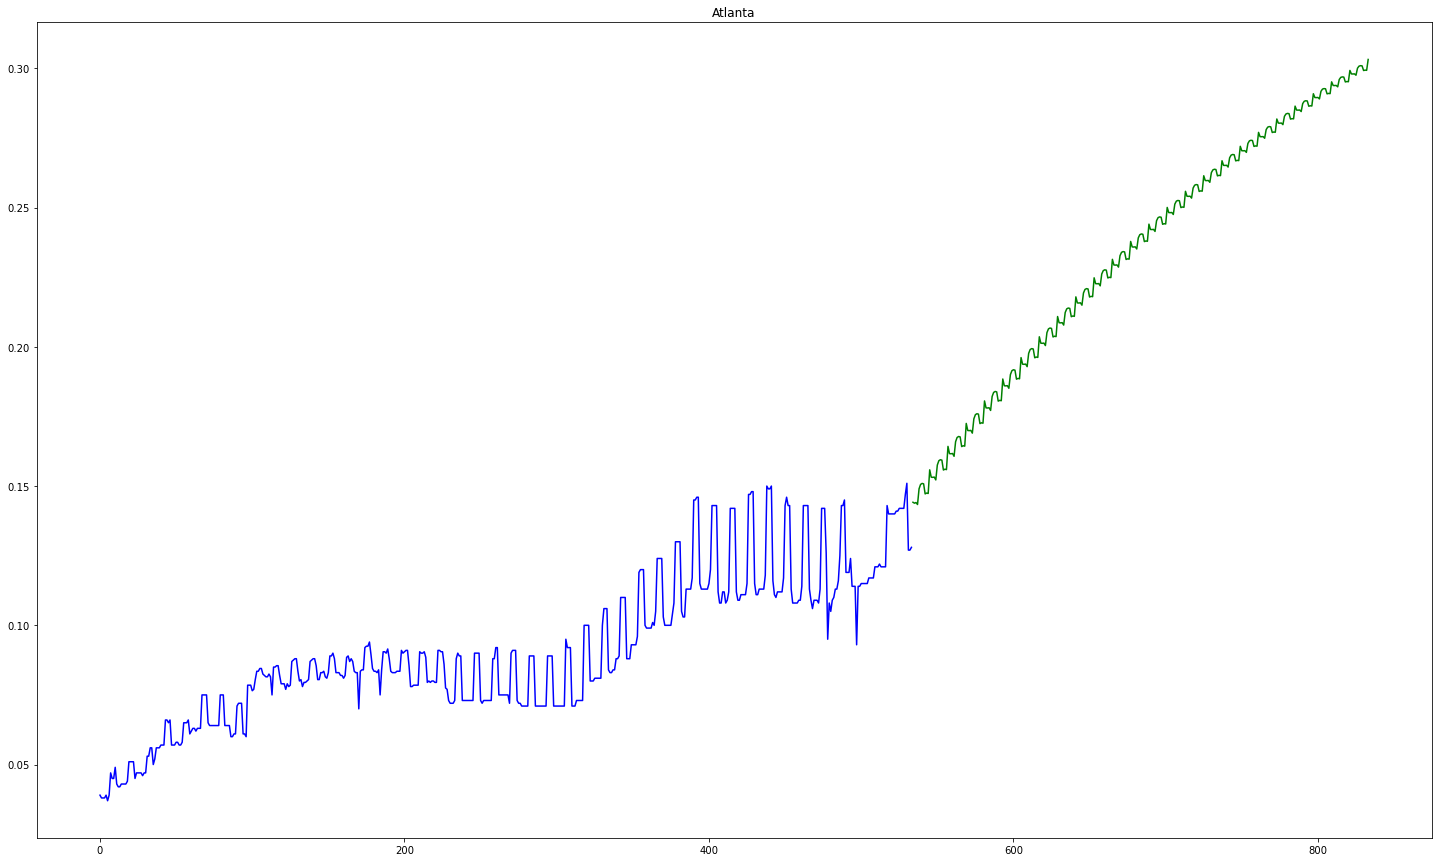

2023-07-04 04:19:58.224461  - Starting to forecast for city  Long Beach
Capstone/models/pmdarima_model_Long Beach2023_07.pkl
[0.27102275 0.27248286 0.27061014 0.27301387 0.27048652 0.27110182
 0.27097126 0.27065277 0.27764627 0.27689469 0.27718894 0.27869128
 0.27995038 0.28122978 0.27947463 0.2818197  0.27941273 0.28003599
 0.27993993 0.27966259 0.28643626 0.28574187 0.28605568 0.28753416
 0.2887781  0.29004156 0.28837998 0.29067081 0.28838079 0.28901193
 0.28894959 0.28871244 0.29527223 0.29463357 0.29496652 0.29642192
 0.29765123 0.29889932 0.29732885 0.29956704 0.29739089 0.29802983
 0.29800039 0.29780247 0.30415437 0.30357    0.30392169 0.30535477
 0.30657    0.30780329 0.30632147 0.30850865 0.30644327 0.3070899
 0.30709259 0.30693292 0.31308296 0.31255144 0.31292145 0.314333
 0.3155347  0.31675376 0.31535814 0.31749592 0.31553825 0.31619248
 0.3162265  0.31610413 0.32205832 0.32157821 0.32196615 0.32335694
 0.32454566 0.32575106 0.32443921 0.32652922 0.32467617 0.32533793
 0.3254

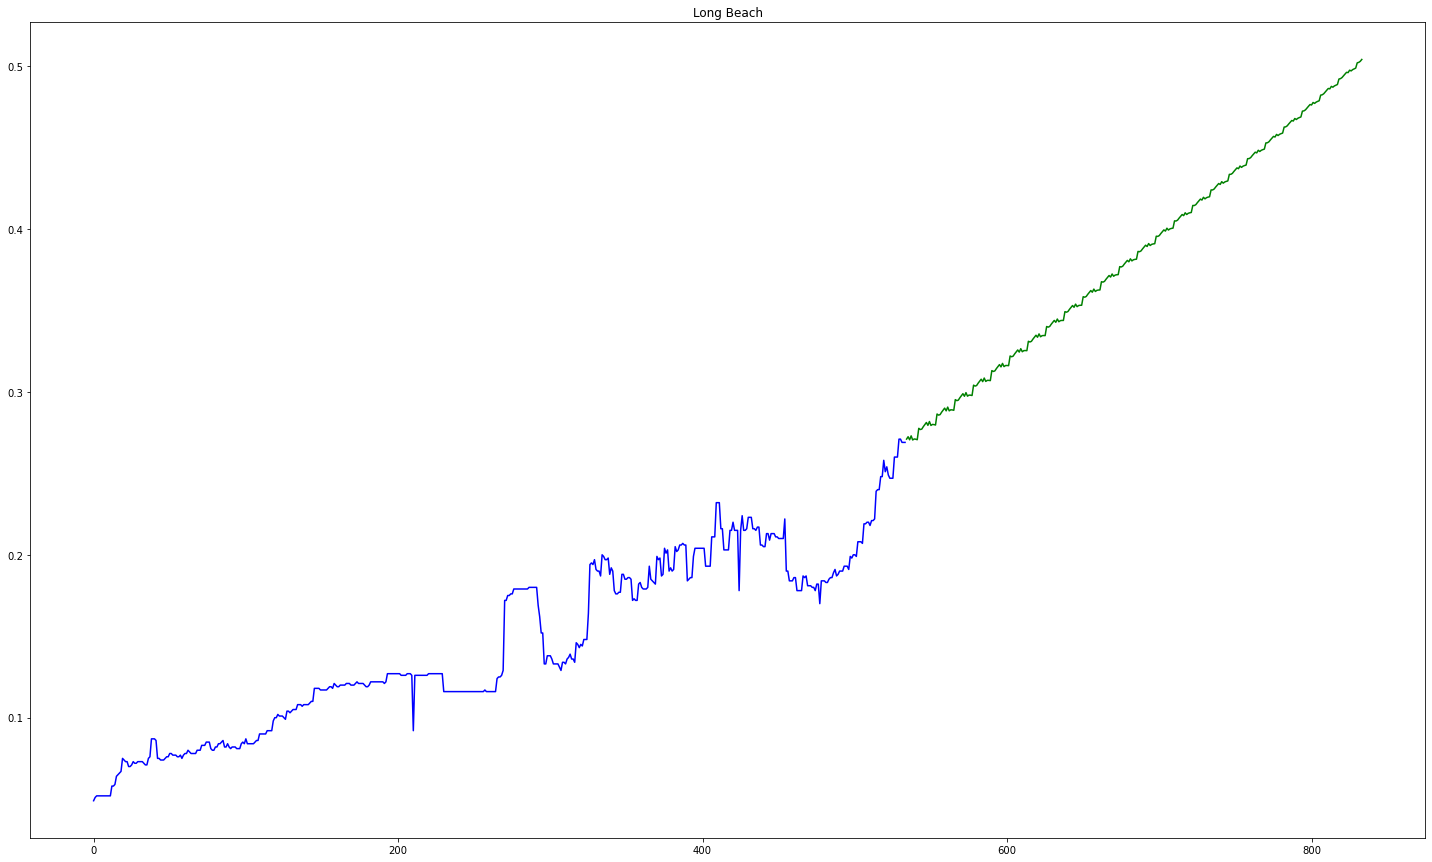

2023-07-04 04:19:58.544914  - Starting to forecast for city  Miami
Capstone/models/pmdarima_model_Miami2023_07.pkl
[0.14609044 0.14625556 0.14642063 0.14658567 0.14675067 0.14691563
 0.14708055 0.14724543 0.14741027 0.14757507 0.14773983 0.14790455
 0.14806924 0.14823388 0.14839849 0.14856306 0.14872758 0.14889207
 0.14905652 0.14922094 0.14938531 0.14954965 0.14971394 0.1498782
 0.15004242 0.1502066  0.15037075 0.15053485 0.15069892 0.15086295
 0.15102694 0.1511909  0.15135481 0.15151869 0.15168253 0.15184634
 0.1520101  0.15217383 0.15233752 0.15250117 0.15266479 0.15282837
 0.15299191 0.15315541 0.15331888 0.15348231 0.1536457  0.15380906
 0.15397238 0.15413566 0.1542989  0.15446211 0.15462528 0.15478842
 0.15495152 0.15511458 0.15527761 0.15544059 0.15560355 0.15576646
 0.15592934 0.15609219 0.156255   0.15641777 0.15658051 0.1567432
 0.15690587 0.1570685  0.15723109 0.15739365 0.15755617 0.15771865
 0.1578811  0.15804352 0.15820589 0.15836824 0.15853055 0.15869282
 0.15885505 0.15

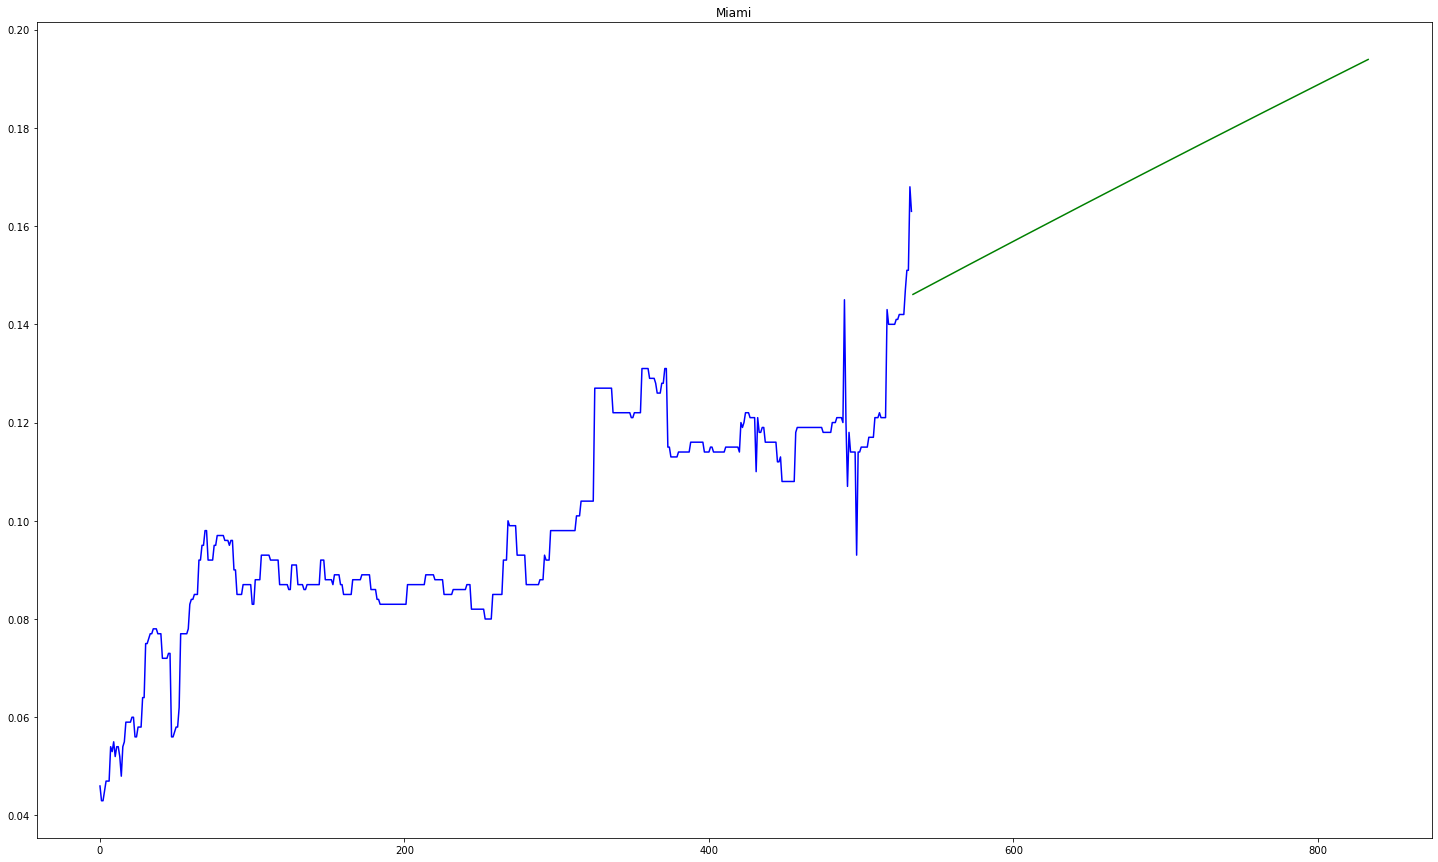

2023-07-04 04:19:58.854213  - Starting to forecast for city  Minneapolis
Capstone/models/pmdarima_model_Minneapolis2023_07.pkl
[0.16344173 0.16447353 0.16415123 0.1669428  0.18423403 0.18290657
 0.18252509 0.18314376 0.16885167 0.16624931 0.16486905 0.16562084
 0.1673848  0.16828496 0.1680038  0.17043864 0.18549873 0.1843438
 0.18401186 0.18455017 0.172103   0.16983387 0.16862999 0.16928574
 0.17082406 0.17160893 0.17136379 0.17348633 0.18659889 0.18559423
 0.18530545 0.18577376 0.17493679 0.1729592  0.17190974 0.1724814
 0.17382225 0.17450626 0.17429263 0.17614208 0.18755576 0.18668195
 0.18643076 0.18683811 0.17740559 0.17568282 0.17476838 0.17526651
 0.17643473 0.17703057 0.17684448 0.17845535 0.18838791 0.187628
 0.18740954 0.18776381 0.17955563 0.17805538 0.17725891 0.17769278
 0.17871021 0.17922908 0.17906704 0.18046963 0.18911152 0.18845074
 0.18826076 0.18856883 0.18142748 0.1801214  0.17942791 0.1798057
 0.18069151 0.18114322 0.18100215 0.18222306 0.18974068 0.18916614
 0.1890

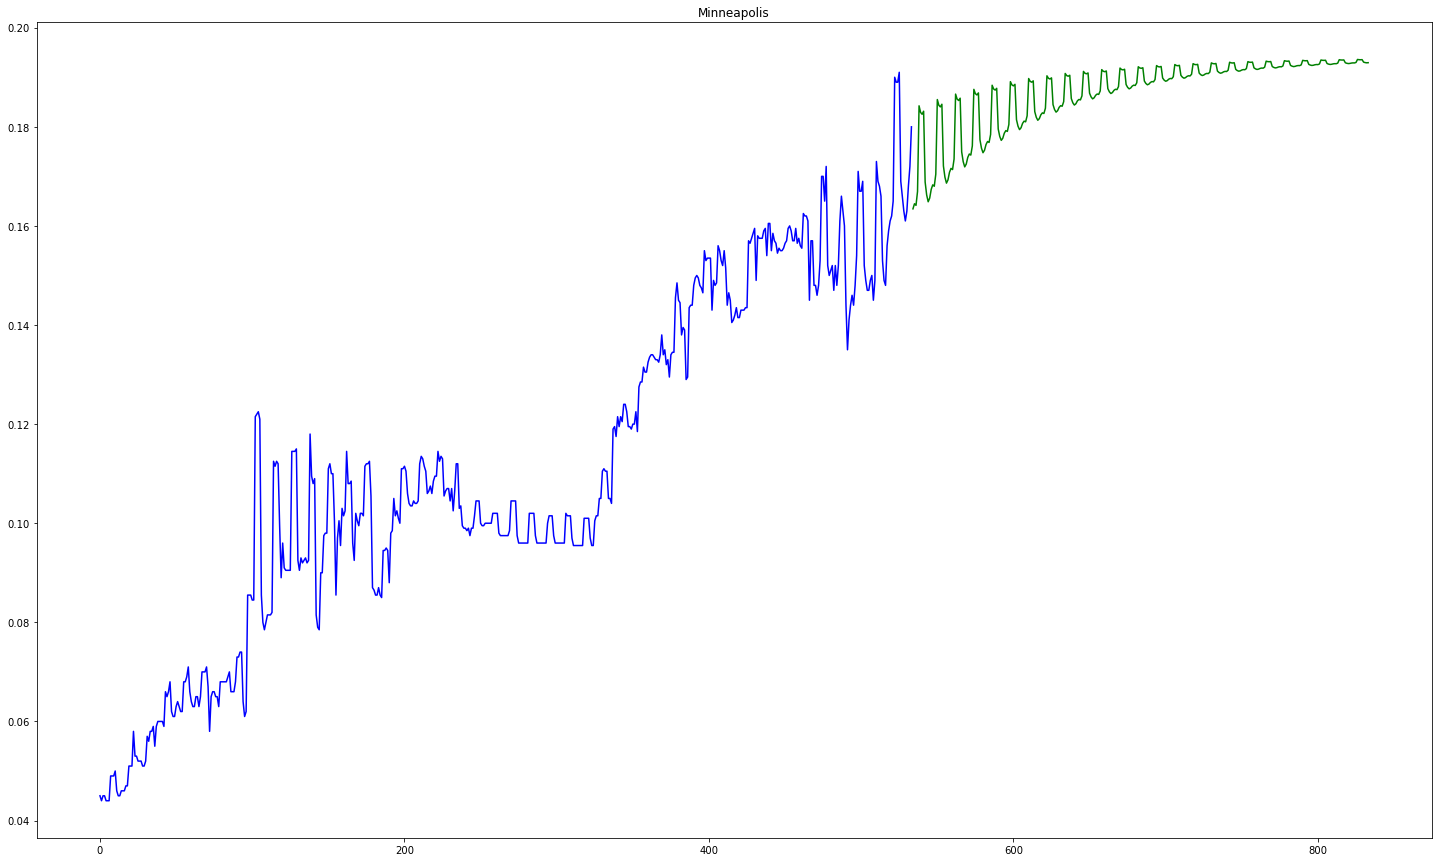

In [520]:
city = 'Seattle'
filepath = 'Capstone/models/'
filepath2 = 'Capstone/predictions/'

current_year = datetime.now().year
current_month = datetime.now().strftime('%m')
y_m = str(current_year) + "_" +  current_month
for city in cities['city']:
    print(datetime.now(), " - Starting to forecast for city ", city)
    pkl_filename = filepath + 'pmdarima_model_' + city + y_m + '.pkl'
    print(pkl_filename)

    dffb = dff[dff['city'] == city]
    y = dffb.sort_values('date')['value']
    #print(dffb)

    with open(pkl_filename, 'rb') as pkl:
        #forecasts = pmdarima_model.predict(test.shape[0])
        forecasts = pickle.load(pkl).predict(n_periods=300)
        print(forecasts)
        
        forecast_filename = filepath2 + 'prediction_' + city + y_m + '.csv'
        pd.DataFrame(forecasts, columns = ['price']).to_csv(forecast_filename, index = False)
        # Visualize the forecasts (blue=train, green=forecasts)
        len(y) + len(forecasts)
        x = np.arange(len(y) + len(forecasts))
        #print(x.shape)
        size = (len(y))
        #print(size)
        
        plt.figure(figsize=(25, 15))
        plt.plot(x[:size], y, c='blue')
        plt.plot(x[size:], forecasts, c='green')
        plt.title(city)

        plt.show()

In [416]:
len(y) + len(forecasts)

894

In [510]:
data_folder = "Capstone/data/"

In [511]:
dff.to_csv(data_folder + "city_prices_imputed.csv", index = False)

In [513]:
cities.to_csv(data_folder + "cities_geocoded.csv", index = False)

In [515]:
json_cities = cities.to_json(orient = 'records')

In [516]:
with open(data_folder + "cities_geocoded.json", 'w') as file:
    # Write the JSON data to the file
    json.dump(json_cities, file)